In [141]:
import pandas as pd
import json
from json import loads,dumps
from pandas.io.json import json_normalize
import os
from tqdm import tqdm
import gc
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 500)
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder  
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score
import lightgbm as lgb 


credits: https://stackoverflow.com/a/36644425/11910771

Below two functions are fpr extracting the data from columns that have data in .json format or datetime data.

In [2]:
def datetime_pre_process(dataframe):
  dataframe['date'] = pd.to_datetime(dataframe['date'],format='%Y%m%d')# defining the format of date column
  dataframe['year'] = dataframe['date'].dt.year# extracting year
  dataframe['month'] = dataframe['date'].dt.month# extracting month
  dataframe['day'] = dataframe['date'].dt.day# extracting day
  dataframe['visit_hour'] = (dataframe['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

  return dataframe

In [3]:
def load_df(csv_path):
  JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
  dfs = pd.read_csv(csv_path, sep=',',
          converters={column: json.loads for column in JSON_COLUMNS}, 
          dtype={'fullVisitorId': 'str'}, # Important!!
          chunksize=100000)
  for number,df in enumerate(dfs):
      df.reset_index(drop=True, inplace=True)
      for column in JSON_COLUMNS:
          column_as_df = pd.json_normalize(df[column])
          column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
          df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

      #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
      use_df = df[features]
      del df
      gc.collect()
      if number>0:
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
      else:
        ans = use_df
      #print(ans.shape)
  ans = datetime_pre_process(ans)    
  return ans

In [4]:
if not os.path.isfile('train_df_without_json.pkl'):
    train_df = load_df(csv_path='train_v2.csv')
    train_df.to_pickle('train_df_without_json.pkl')
else:
    train_df = pd.read_pickle('train_df_without_json.pkl')

In [5]:
if not os.path.isfile('test_df_without_json.pkl'):
    test_df = load_df(csv_path='test_v2.csv')
    test_df.to_pickle('test_df_without_json.pkl')
else:
    test_df = pd.read_pickle('test_df_without_json.pkl')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 37 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   channelGrouping             object        
 1   date                        datetime64[ns]
 2   fullVisitorId               object        
 3   visitId                     int64         
 4   visitNumber                 int64         
 5   visitStartTime              int64         
 6   socialEngagementType        object        
 7   device.browser              object        
 8   device.deviceCategory       object        
 9   device.isMobile             bool          
 10  device.operatingSystem      object        
 11  geoNetwork.city             object        
 12  geoNetwork.continent        object        
 13  geoNetwork.country          object        
 14  geoNetwork.metro            object        
 15  geoNetwork.networkDomain    object        
 16  geoNetwork.region 

In [7]:
print('Number of different columns in train and test data:',len(list(set(train_df.columns)-set(test_df.columns))))

Number of different columns in train and test data: 0


In [8]:
print('Train Data Shape:{}\nTest Data Shape:{}'.format(train_df.shape,test_df.shape))

Train Data Shape:(1708337, 37)
Test Data Shape:(401589, 37)


In [9]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
revenue_group = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
non_rev_gen_customers = revenue_group[revenue_group['totals.transactionRevenue']==0]
rev_gen_customers = revenue_group[revenue_group['totals.transactionRevenue']>0]
print('{}% of customers are generating all the revenue'.format(len(rev_gen_customers)*100/(len(rev_gen_customers)+len(non_rev_gen_customers))))

1.219357421830736% of customers are generating all the revenue


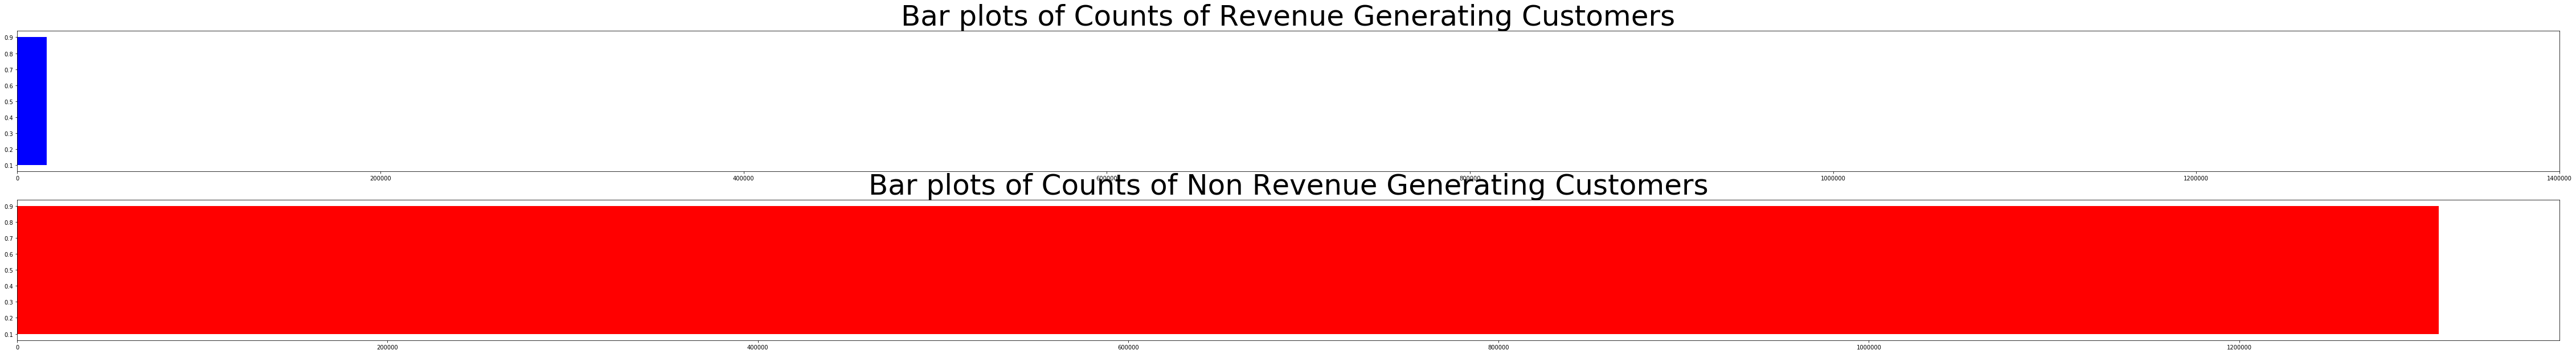

In [10]:
plt.figure(figsize=(80,10))
plt.subplot(2,1,1)
plt.title('Bar plots of Counts of Revenue Generating Customers',fontdict = {'fontsize' : 50})
plt.barh(.5,len(rev_gen_customers),color='b')
x1,x2,y1,y2 = plt.axis()
plt.axis([0,1400000,y1,y2])
plt.subplot(2,1,2)
plt.title('Bar plots of Counts of Non Revenue Generating Customers',fontdict = {'fontsize' : 50})
plt.barh(.5,len(non_rev_gen_customers),color='r')
plt.savefig('Final_plots/Bar Plots_Rev_Non_rev.png')
plt.show()


This is bar plot of the number of Non Revenue Generating Customers and Revenue Generating Customers. We can infer that most customers visit the store and wont make any transation.

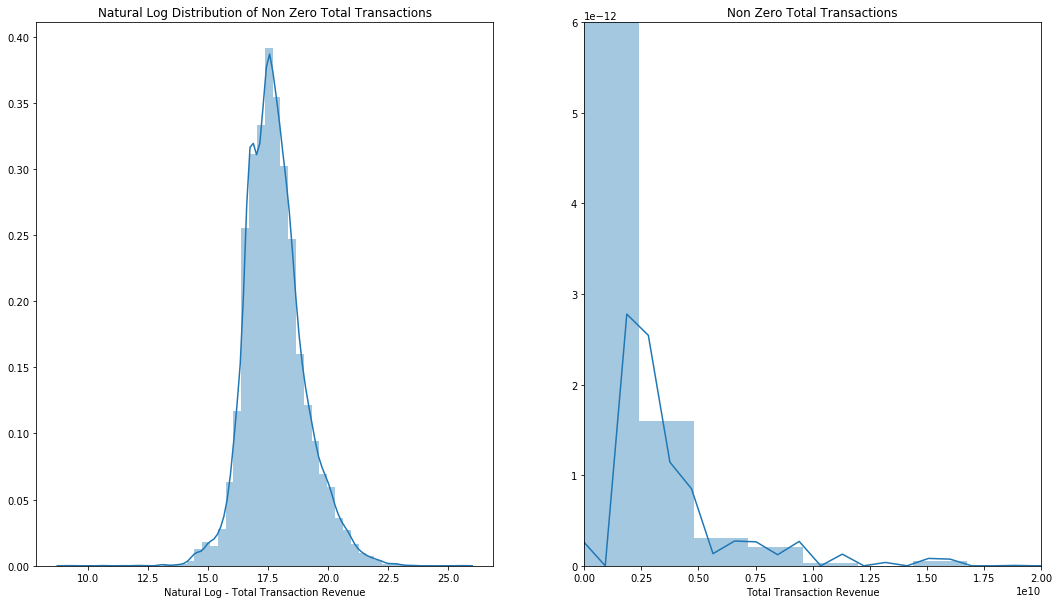

In [11]:
revenue_generating_customer_transactions = revenue_group['totals.transactionRevenue'][revenue_group['totals.transactionRevenue']>0]
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
sns.distplot(np.log(revenue_generating_customer_transactions))
plt.title("Natural Log Distribution of Non Zero Total Transactions")
plt.xlabel("Natural Log - Total Transaction Revenue")

plt.subplot(1,2,2)
sns.distplot(revenue_generating_customer_transactions)
plt.xlim(0,.2*10**11)
plt.ylim(0,.06*10**-10)
plt.title("Non Zero Total Transactions")
plt.xlabel("Total Transaction Revenue")
plt.savefig('Final_plots/target_univariant.png')

This is distribution plot of target variable(Total Transaction Revenue).

In [12]:
print('There are about {} null values in our target variable'.format(train_df["totals.transactionRevenue"].isnull().sum()))

There are about 1689823 null values in our target variable


These null values indicate that the session didnt have any transation so it was marked as Nan. So I will be filling the Nan entries with zero.

In [13]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].fillna(value=0)

channelGrouping

In [14]:
print('There are about {} null values in channelGrouping'.format(train_df['channelGrouping'].isnull().sum()))

There are about 0 null values in channelGrouping


In [15]:
train_df['channelGrouping'].value_counts()

Organic Search    738963
Social            354971
Direct            273134
Referral          211307
Display            51283
Paid Search        45627
Affiliates         32915
(Other)              137
Name: channelGrouping, dtype: int64

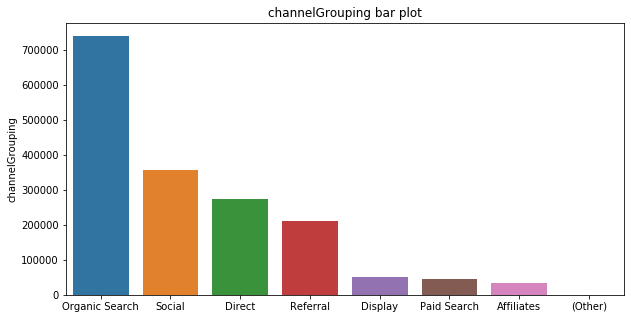

In [16]:
plt.figure(figsize=(10,5))
plt.title('channelGrouping bar plot')
sns.barplot(x=train_df['channelGrouping'].value_counts().index, y=train_df['channelGrouping'].value_counts())
plt.savefig('Final_plots/channel_group.png')

device.browser

In [17]:
print('There are about {} null values in device.browser'.format(train_df['device.browser'].isnull().sum()))

There are about 0 null values in device.browser


In [18]:
train_df['device.browser'].value_counts()

Chrome                                                  1173056
Safari                                                   312165
Firefox                                                   63845
Internet Explorer                                         35474
Android Webview                                           34266
                                                         ...   
dohyinzpvbsktjeguxmrqcwafl                                    1
;__CT_JOB_ID__:58e2ecba-7666-4a10-b498-8216457ce472;          1
Reddit                                                        1
subjectAgent: NoticiasBoom                                    1
ecwozghsufybtdkjrlvxpamiqn                                    1
Name: device.browser, Length: 129, dtype: int64

In [19]:
for i in train_df['device.browser'].value_counts().index:
  print(i)

Chrome
Safari
Firefox
Internet Explorer
Android Webview
Edge
Samsung Internet
Opera Mini
Safari (in-app)
Opera
UC Browser
YaBrowser
Amazon Silk
Coc Coc
Android Browser
Mozilla Compatible Agent
MRCHROME
Maxthon
Puffin
BlackBerry
Nintendo Browser
Nokia Browser
Iron
osee2unifiedRelease
SeaMonkey
Mozilla
LYF_LS_4002_12
Seznam
Apple-iPhone7C2
Playstation Vita Browser
(not set)
Lunascape
+Simple Browser
Nichrome
0
Konqueror
YE
DESKTOP
Browser
Autn-WKOOP
DASH_JR_3G
no-ua
CSM Click
Netscape
LYF_LS_4002_11
ThumbSniper
SAMSUNG-SM-B355E Opera
MQQBrowser
NokiaE52-1
Android Runtime
Amazon.com
;__CT_JOB_ID__:85da5736-a78e-45a9-837e-f5a53e5cd725;
fspmihbxzowgnuctrqykjlvade
uybjlgntzwpacihremkqsxdovf
mhwxofpevcagujznbsiqlrkytd
;__CT_JOB_ID__:2e0eca60-83ab-482d-bb81-343d113254fb;
ohfgqlpiuyknvmbctszjarxdwe
vjebamzrktwcysxpdlonhiufqg
HTC802t_TD
;__CT_JOB_ID__:97909e28-4228-4b55-8ad5-cc791f2b583c;
;__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;
;__CT_JOB_ID__:a24a8978-e5e8-4dc9-af66-c4ed89ea25d7;
lx

We can see that there are some of the categories in this field that are random. So it best if we can replace them with unknown. We can observe that the random strings had a minimum string length.

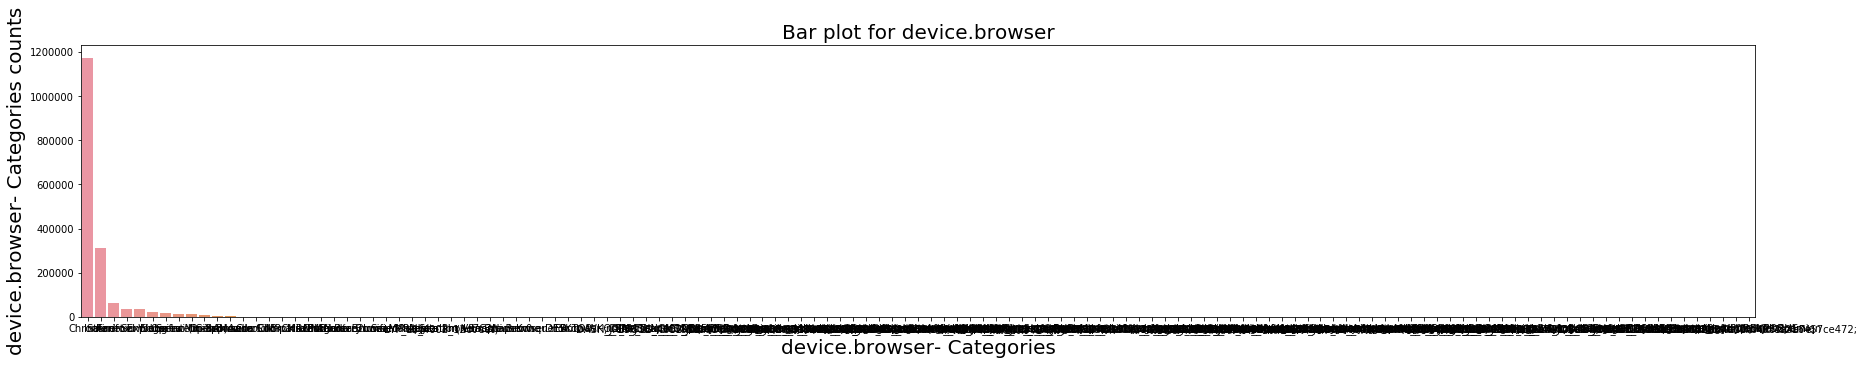

In [20]:
plt.figure(figsize=(30,5))
sns.barplot(x=train_df['device.browser'].value_counts().index, y=train_df['device.browser'].value_counts())
plt.title('Bar plot for device.browser',fontsize=20)
plt.xlabel('device.browser- Categories',fontsize=20)
plt.ylabel('device.browser- Categories counts',fontsize=20)
plt.savefig('device.browser.png')

As we can see in this only small percentage of customers are from browers other than Chrome, Safari, Frifox, IE.

Lets look at the browser as per percentage

In [21]:
for browser,counts in zip(train_df['device.browser'].value_counts().index,train_df['device.browser'].value_counts()):
  print('{} is used by {} of customers'.format(browser,round((counts/len(train_df)),2)*100))

Chrome is used by 69.0 of customers
Safari is used by 18.0 of customers
Firefox is used by 4.0 of customers
Internet Explorer is used by 2.0 of customers
Android Webview is used by 2.0 of customers
Edge is used by 1.0 of customers
Samsung Internet is used by 1.0 of customers
Opera Mini is used by 1.0 of customers
Safari (in-app) is used by 1.0 of customers
Opera is used by 1.0 of customers
UC Browser is used by 0.0 of customers
YaBrowser is used by 0.0 of customers
Amazon Silk is used by 0.0 of customers
Coc Coc is used by 0.0 of customers
Android Browser is used by 0.0 of customers
Mozilla Compatible Agent is used by 0.0 of customers
MRCHROME is used by 0.0 of customers
Maxthon is used by 0.0 of customers
Puffin is used by 0.0 of customers
BlackBerry is used by 0.0 of customers
Nintendo Browser is used by 0.0 of customers
Nokia Browser is used by 0.0 of customers
Iron is used by 0.0 of customers
osee2unifiedRelease is used by 0.0 of customers
SeaMonkey is used by 0.0 of customers
Mozi

After Opera browser we can see that all the other browsers are less than 1% so it would be better if we can group these into one group. So lets create a list of browsers that actually has some sizable chunk of customers.

In [22]:
popular_browsers = ['Chrome','Safari','Firefox','Internet Explorer','Android Webview','Edge','Samsung Internet','Opera Mini','Safari (in-app)','Opera']

In [23]:
train_df['device.browser'] = train_df['device.browser'].apply(lambda x: x if x in popular_browsers else 'unpopular_browser')

In [24]:
train_df['device.browser'].value_counts()

Chrome               1173056
Safari                312165
Firefox                63845
Internet Explorer      35474
Android Webview        34266
Edge                   20543
Samsung Internet       15792
Opera Mini             15018
unpopular_browser      14386
Safari (in-app)        14207
Opera                   9585
Name: device.browser, dtype: int64

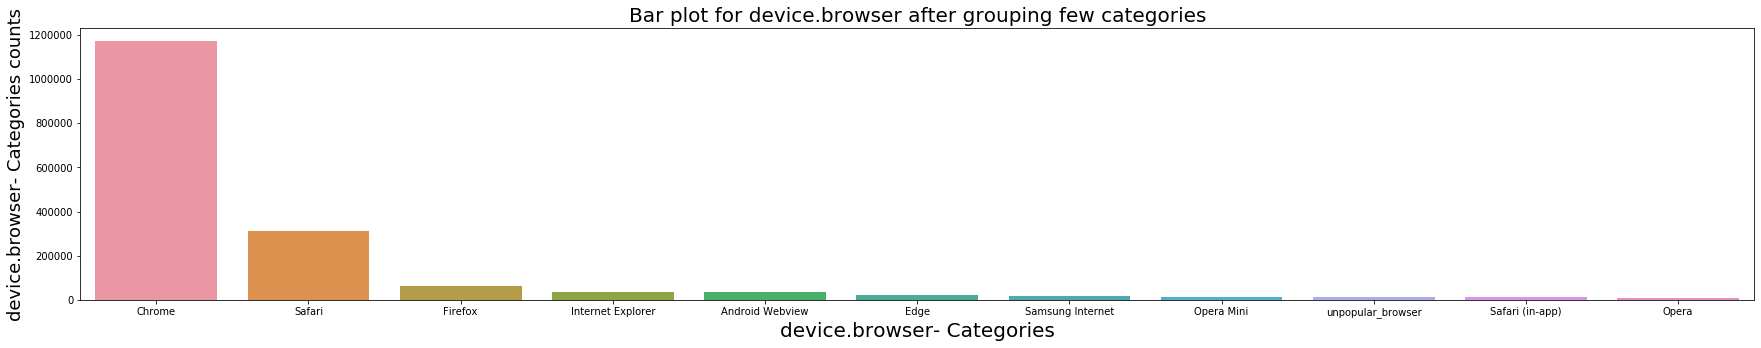

In [25]:
plt.figure(figsize=(30,5))
sns.barplot(x=train_df['device.browser'].value_counts().index, y=train_df['device.browser'].value_counts())
plt.title('Bar plot for device.browser after grouping few categories',fontsize=20)
plt.xlabel('device.browser- Categories',fontsize=20)
plt.ylabel('device.browser- Categories counts',fontsize=18)
plt.savefig('device.browser after grouping few categories.png')

From this bar plots its clear that the pre-processing we have perfomed only resulted in a new category that grouped alot of categories that had very little counts.

We can infer from the above plot that Chrome and Safari are the most used by our customers.

Text(0, 0.5, 'device.browser- Average revene per browser')

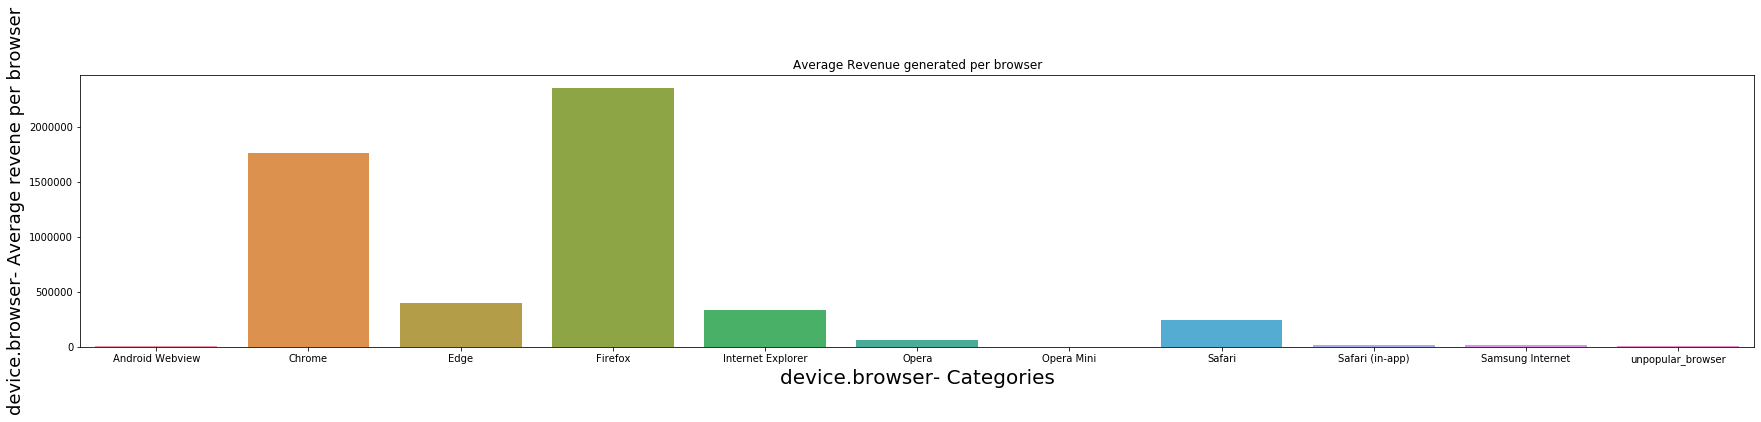

In [26]:
revenue_browser = train_df[['totals.transactionRevenue','device.browser']].groupby('device.browser')['totals.transactionRevenue'].sum()
browser_count = train_df[['totals.transactionRevenue','device.browser']].groupby('device.browser')['totals.transactionRevenue'].count()

browser_average = [browser_rev/(browser_count+.001) for browser_rev,browser_count in zip(revenue_browser, browser_count)]
browser_names = [i for i in revenue_browser.index]

plt.figure(figsize=(30,5))
plt.title('Average Revenue generated per browser')
sns.barplot(x=browser_names, y=browser_average)
plt.xlabel('device.browser- Categories',fontsize=20)
plt.ylabel('device.browser- Average revene per browser',fontsize=18)


As we can see in this plot, majority of the revenue is generated through Chrome, Edge, Firefox(most) , IE and Safari. This plot also indicates that relation of browser and revenue generated.

So if test query data observtion is provided to the model and if the browser is Firfox then most likely the predicted revenue would be higher than the rest of the browsers.

And from my understanding Safari has lower average revenue because of the Apple ecosystem. Its very rare that an Apple user would buy an Google product because it will not work well with any Apple products.

device.deviceCategory

In [27]:
print('There are about {} null values in device.deviceCategory'.format(train_df['device.deviceCategory'].isnull().sum()))

There are about 0 null values in device.deviceCategory


Text(0, 0.5, 'device.category- Category Count')

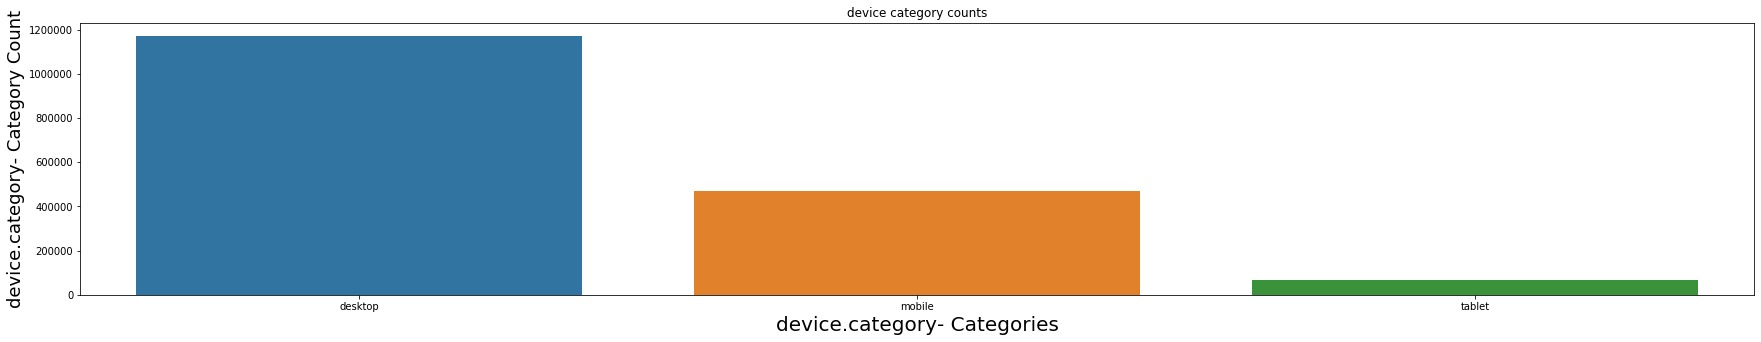

In [28]:
plt.figure(figsize=(30,5))
plt.title('device category counts')
sns.barplot(x=train_df['device.deviceCategory'].value_counts().index, y=train_df['device.deviceCategory'].value_counts())
plt.xlabel('device.category- Categories',fontsize=20)
plt.ylabel('device.category- Category Count',fontsize=18)


Text(0, 0.5, 'device.deviceCategory- Average revene per deviceCategory')

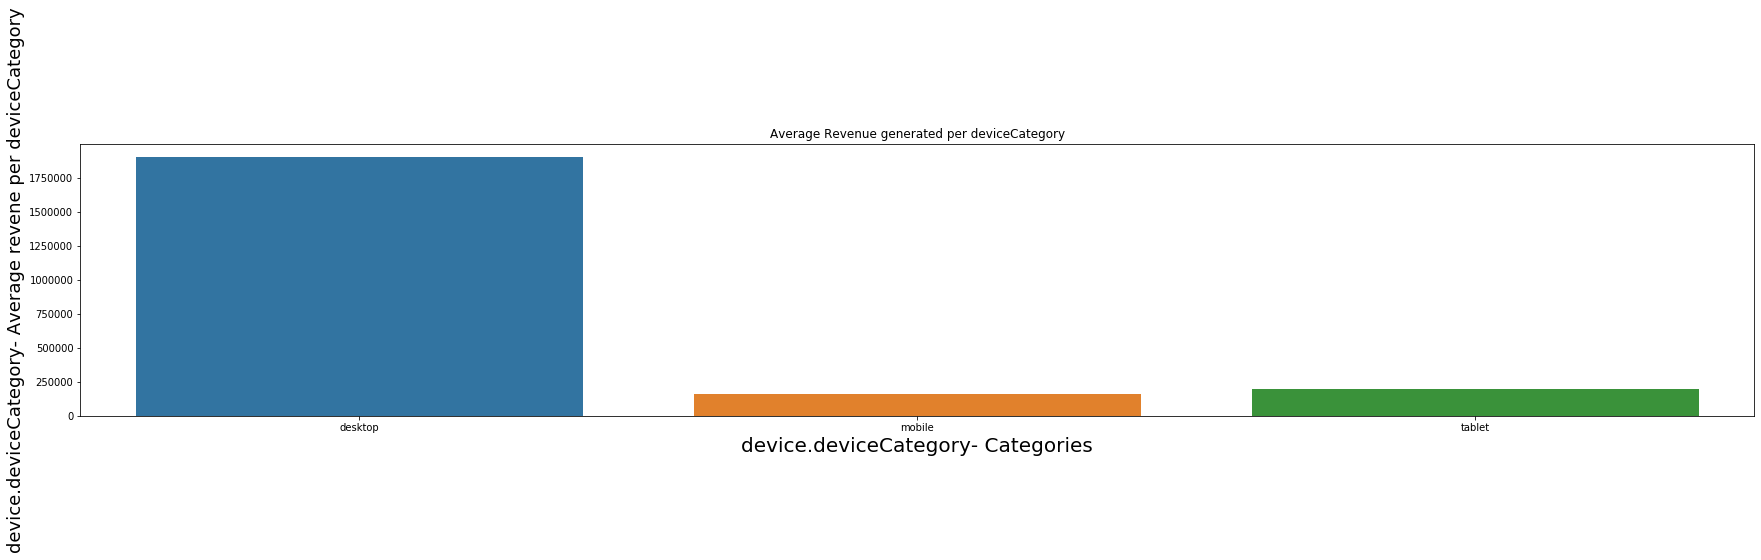

In [29]:
revenue_category = train_df[['totals.transactionRevenue','device.deviceCategory']].groupby('device.deviceCategory')['totals.transactionRevenue'].sum()
category_count = train_df[['totals.transactionRevenue','device.deviceCategory']].groupby('device.deviceCategory')['totals.transactionRevenue'].count()

category_average = [category_rev/category_count for category_rev,category_count in zip(revenue_category, category_count)]
category_names = [i for i in revenue_category.index]

plt.figure(figsize=(30,5))
plt.title('Average Revenue generated per deviceCategory')
sns.barplot(x=category_names, y=category_average)
plt.xlabel('device.deviceCategory- Categories',fontsize=20)
plt.ylabel('device.deviceCategory- Average revene per deviceCategory',fontsize=18)


device.isMobile

In [30]:
print('There are about {} null values in device.isMobile'.format(train_df['device.isMobile'].isnull().sum()))

There are about 0 null values in device.isMobile


Text(0, 0.5, 'device.isMobile- Category Count')

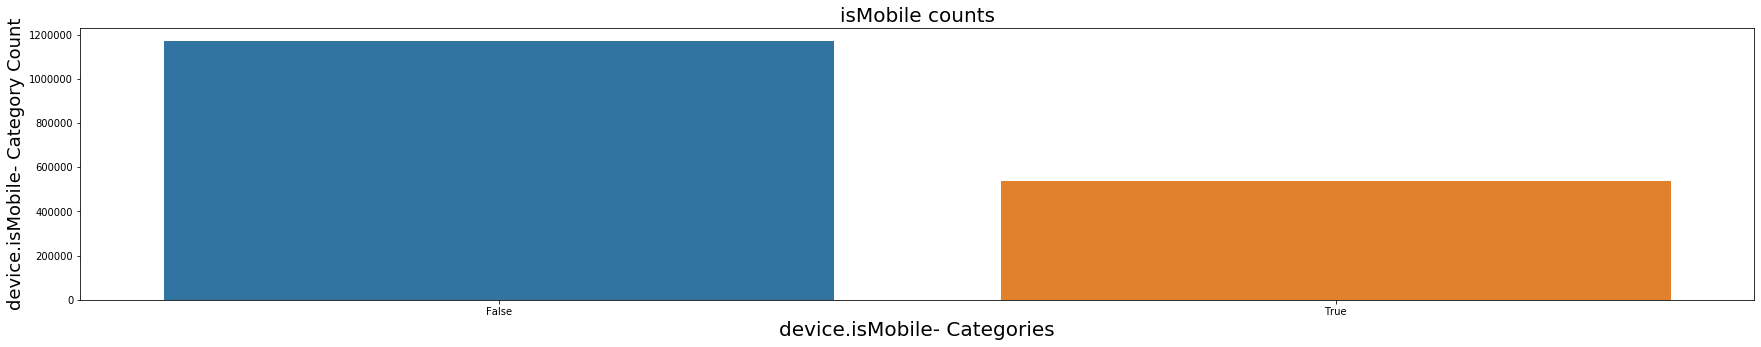

In [31]:
plt.figure(figsize=(30,5))
plt.title('isMobile counts',fontsize=20)
sns.barplot(x=train_df['device.isMobile'].value_counts().index, y=train_df['device.isMobile'].value_counts())
plt.xlabel('device.isMobile- Categories',fontsize=20)
plt.ylabel('device.isMobile- Category Count',fontsize=18)


Text(0, 0.5, 'device.isMobile- Average revene per deviceCategory')

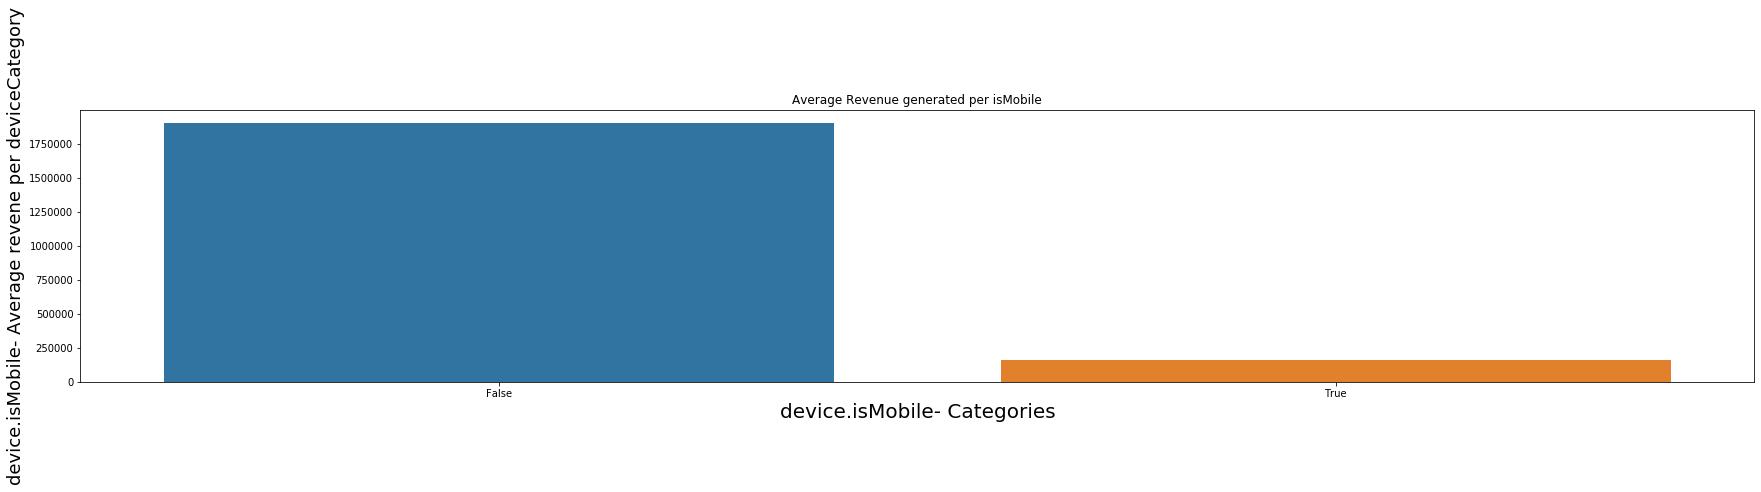

In [32]:
revenue_category = train_df[['totals.transactionRevenue','device.isMobile']].groupby('device.isMobile')['totals.transactionRevenue'].sum()
category_count = train_df[['totals.transactionRevenue','device.isMobile']].groupby('device.isMobile')['totals.transactionRevenue'].count()

category_average = [category_rev/category_count for category_rev,category_count in zip(revenue_category, category_count)]
category_names = [i for i in revenue_category.index]

plt.figure(figsize=(30,5))
plt.title('Average Revenue generated per isMobile')
sns.barplot(x=category_names, y=category_average)
plt.xlabel('device.isMobile- Categories',fontsize=20)
plt.ylabel('device.isMobile- Average revene per deviceCategory',fontsize=18)


We can clearly see that when the customer is using mobile the average transaction revenue is much less so this will be a very usefull feature that will determine the revenue prediction.

device.operatingSystem

In [33]:
print('There are about {} null values in device.operatingSystem'.format(train_df['device.operatingSystem'].isnull().sum()))

There are about 0 null values in device.operatingSystem


Text(0, 0.5, 'device.operatingSystem- Category Count')

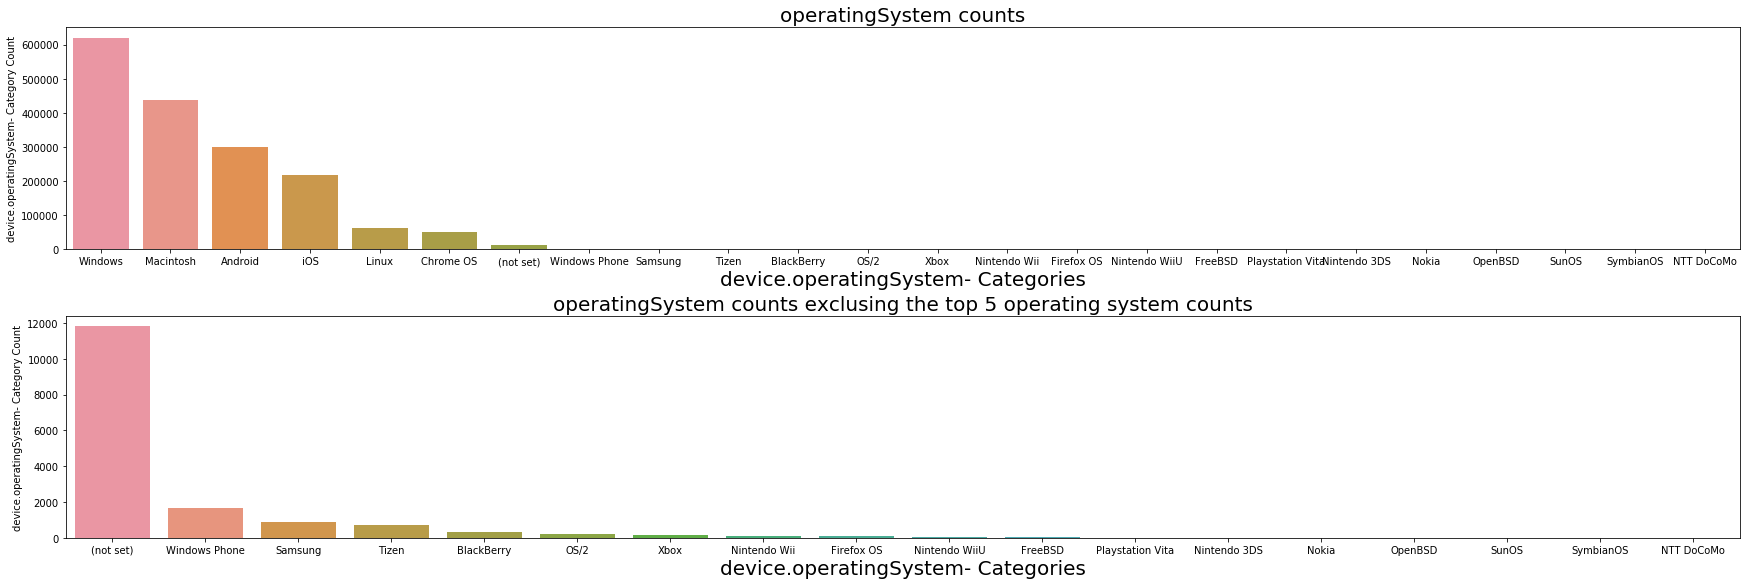

In [34]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('operatingSystem counts',fontsize=20)
sns.barplot(x=train_df['device.operatingSystem'].value_counts().index, y=train_df['device.operatingSystem'].value_counts())
plt.xlabel('device.operatingSystem- Categories',fontsize=20)
plt.ylabel('device.operatingSystem- Category Count',fontsize=10)
plt.subplots_adjust(hspace = .3)
plt.subplot(4,1,2)
plt.title('operatingSystem counts exclusing the top 5 operating system counts',fontsize=20)
sns.barplot(x=train_df['device.operatingSystem'].value_counts().index[6:], y=train_df['device.operatingSystem'].value_counts()[6:])
plt.xlabel('device.operatingSystem- Categories',fontsize=20)
plt.ylabel('device.operatingSystem- Category Count',fontsize=10)


Plot 1: This the overall bar plot of each operating system. If we can see after Windows Phone the counts of each categories are very negligible. Lets look at each category average revenue generated before regrouping those low count categories into one category

Plot 2: In this plot we can see the counts of each operating system(excluding the top 6 operating systems)

So we can recategorise the categories from (not set) to NTT DoCoMo categories to 'Generic Operating System'

In [35]:
operating_systems = ['Windows','Macintosh','Android','iOS','Linux','Chrome OS']
train_df['device.operatingSystem'] = train_df['device.operatingSystem'].apply(lambda x:x if x in operating_systems else 'Generic_OS')

Text(0, 0.5, 'device.operatingSystem- Category Count')

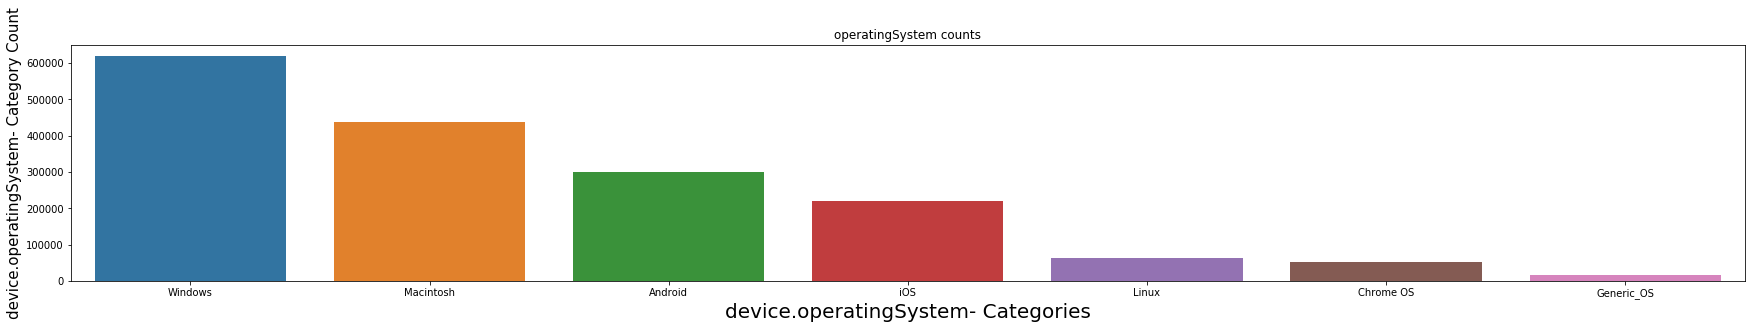

In [36]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('operatingSystem counts')
sns.barplot(x=train_df['device.operatingSystem'].value_counts().index, y=train_df['device.operatingSystem'].value_counts())
plt.xlabel('device.operatingSystem- Categories',fontsize=20)
plt.ylabel('device.operatingSystem- Category Count',fontsize=15)


geoNetwork.city   

In [37]:
print('There are about {} null values in geoNetwork.city'.format(train_df['geoNetwork.city'].isnull().sum()))

There are about 0 null values in geoNetwork.city


In [38]:
len(set(train_df['geoNetwork.city']))

956

Text(0, 0.5, 'device.city- Category Count')

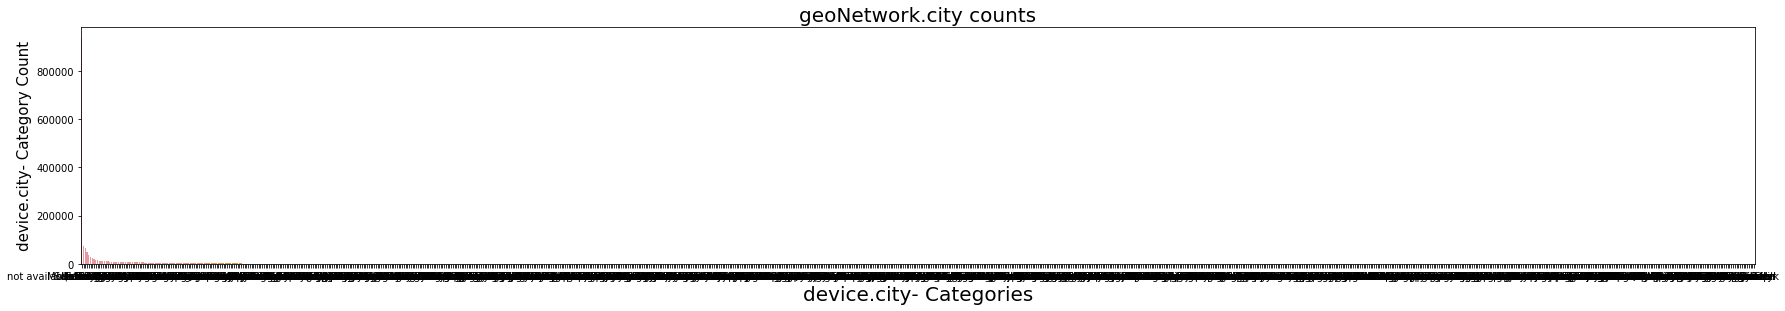

In [39]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('geoNetwork.city counts',fontsize=20)
sns.barplot(x=train_df['geoNetwork.city'].value_counts().index, y=train_df['geoNetwork.city'].value_counts())
plt.xlabel('device.city- Categories',fontsize=20)
plt.ylabel('device.city- Category Count',fontsize=15)


In plot 2 the total numbers of time each city repeates is very less, only 1173.0 time a city has been repeated


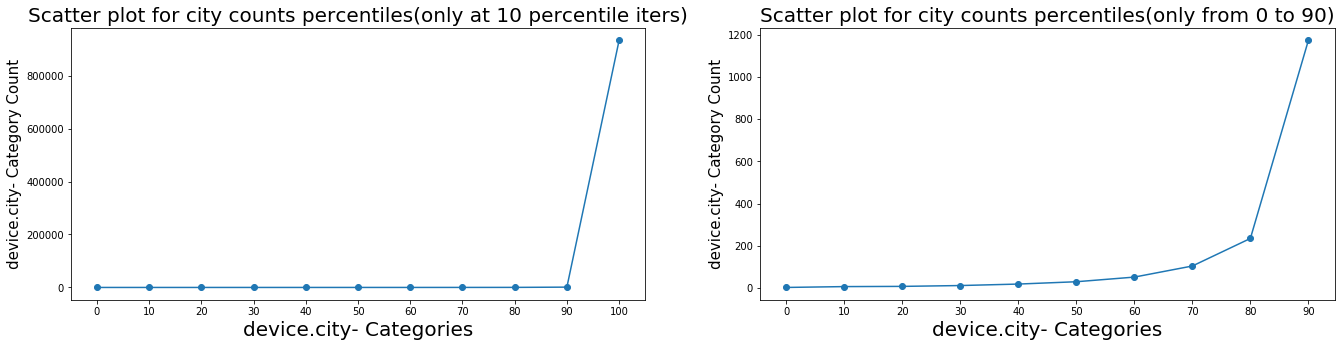

In [40]:
geo_city_value_counts = [i for i in train_df['geoNetwork.city'].value_counts()]
percentile = [i for i in range(0,101,10)]
city_percentiles_values = [np.percentile(geo_city_value_counts,per) for per in percentile]
# print(city_percentiles_values)
percentile = [i for i in range(90,101)]
city_ten_percentiles = [np.percentile(geo_city_value_counts,per) for per in percentile]
percentile_numbers = [i for i in range(0,101,10)]
plt.figure(figsize=(35,5))
plt.subplot(1,3,1)
plt.title('Scatter plot for city counts percentiles(only at 10 percentile iters)',fontsize=20)
plt.scatter(x=percentile_numbers,y=city_percentiles_values)
plt.plot(percentile_numbers,city_percentiles_values)
plt.xticks(percentile_numbers)
plt.xlabel('device.city- Categories',fontsize=20)
plt.ylabel('device.city- Category Count',fontsize=15)

plt.subplot(1,3,2)
plt.title('Scatter plot for city counts percentiles(only from 0 to 90)',fontsize=20)
plt.scatter(x=percentile_numbers[:-1],y=city_percentiles_values[:-1])
plt.plot(percentile_numbers[:-1],city_percentiles_values[:-1])
plt.xticks(percentile_numbers[:-1])
plt.xlabel('device.city- Categories',fontsize=20)
plt.ylabel('device.city- Category Count',fontsize=15)

print('In plot {} the total numbers of time each city repeates is very less, only {} time a city has been repeated'.format(2,np.percentile(city_percentiles_values,90)))
plt.savefig('Final_plots\device.city_pdf.png')

1) We can see that there is only one outlier point, i.e after 90th percentile.

2) In plot 2 the total numbers of time each city repeates is very less, only 1173.0 time a city has been repeated.

So we can group all these cities into one group since they are repeating very few times. 


In [41]:
pre_processed_cities = []
for city_name,city_count in zip(train_df['geoNetwork.city'].value_counts().index,train_df['geoNetwork.city'].value_counts()):
  if ((city_count<(np.percentile(city_percentiles_values,90)) and (max(train_df['totals.transactionRevenue'][train_df['geoNetwork.city']==city_name])<1))):
    pass
  else:
    pre_processed_cities.append(city_name)

train_df['geoNetwork.city'] = train_df['geoNetwork.city'].apply(lambda x: x if x in pre_processed_cities else 'unknown_city')

In [42]:
print('After grouping of cities we have {} categories in this feature'.format(len(train_df['geoNetwork.city'].value_counts())))

After grouping of cities we have 185 categories in this feature


geoNetwork.country

In [43]:
print('There are about {} null values in geoNetwork.country'.format(train_df['geoNetwork.country'].isnull().sum()))

There are about 0 null values in geoNetwork.country


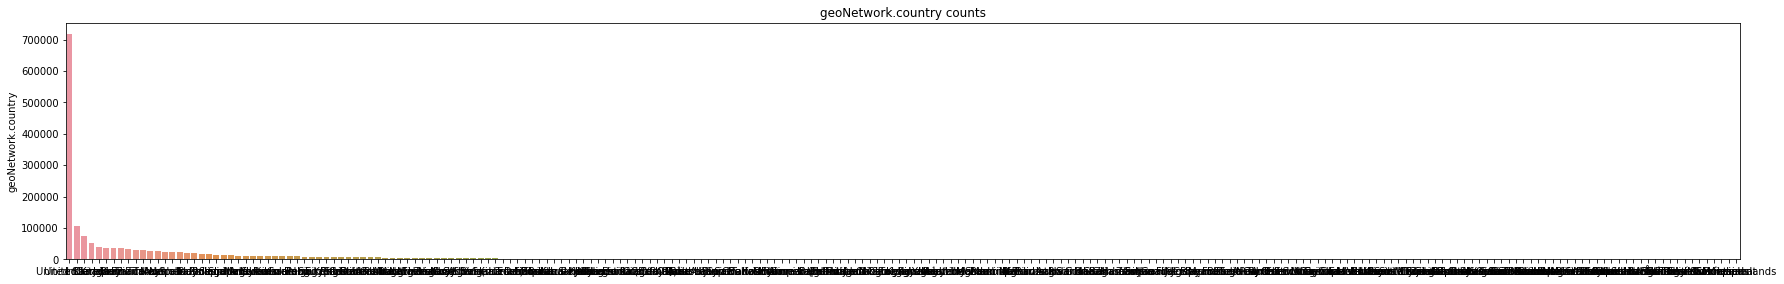

In [44]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('geoNetwork.country counts')
sns.barplot(x=train_df['geoNetwork.country'].value_counts().index, y=train_df['geoNetwork.country'].value_counts())

In plot 2 the total numbers of time each country repeates is very less, only 11780.200000000008 time a country has been repeated


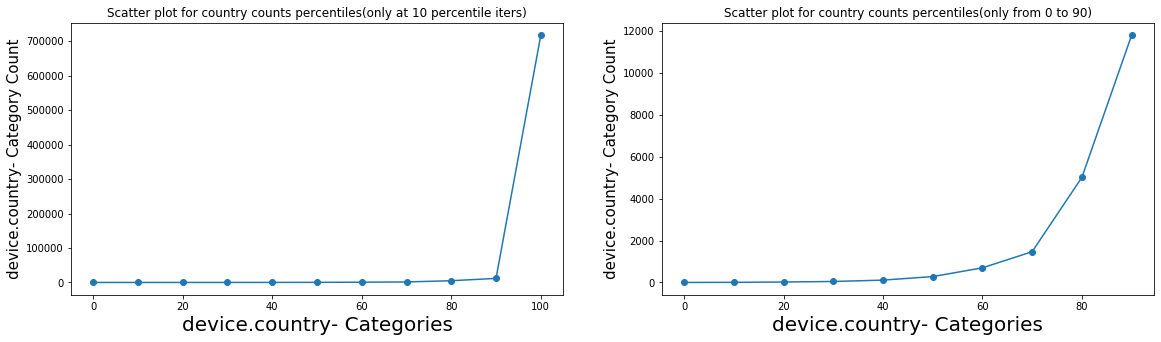

In [45]:
geo_country_value_counts = [i for i in train_df['geoNetwork.country'].value_counts()]
percentile = [i for i in range(0,101,10)]
country_percentiles_values = [np.percentile(geo_country_value_counts,per) for per in percentile]
# print(country_percentiles_values)
percentile = [i for i in range(90,101)]
country_ten_percentiles = [np.percentile(geo_country_value_counts,per) for per in percentile]
percentile_numbers = [i for i in range(0,101,10)]
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.title('Scatter plot for country counts percentiles(only at 10 percentile iters)')
plt.scatter(x=percentile_numbers,y=country_percentiles_values)
plt.plot(percentile_numbers,country_percentiles_values)
plt.xlabel('device.country- Categories',fontsize=20)
plt.ylabel('device.country- Category Count',fontsize=15)

plt.subplot(1,3,2)
plt.title('Scatter plot for country counts percentiles(only from 0 to 90)')
plt.scatter(x=percentile_numbers[:-1],y=country_percentiles_values[:-1])
plt.xlabel('device.country- Categories',fontsize=20)
plt.ylabel('device.country- Category Count',fontsize=15)
plt.plot(percentile_numbers[:-1],country_percentiles_values[:-1])
print('In plot {} the total numbers of time each country repeates is very less, only {} time a country has been repeated'.format(2,np.percentile(country_percentiles_values,90)))

As we can see in plot 2 for countries below 60th percentile, these countries are repeated on very few occations compared to the rest.

In [46]:
pre_processed_country = []
for country_name,country_count in zip(train_df['geoNetwork.country'].value_counts().index,train_df['geoNetwork.country'].value_counts()):
  if country_count<(np.percentile(country_percentiles_values,60)):
    pass
  else:
    pre_processed_country.append(country_name)

train_df['geoNetwork.country'] = train_df['geoNetwork.country'].apply(lambda x: x if x in pre_processed_country else 'unknown_country')

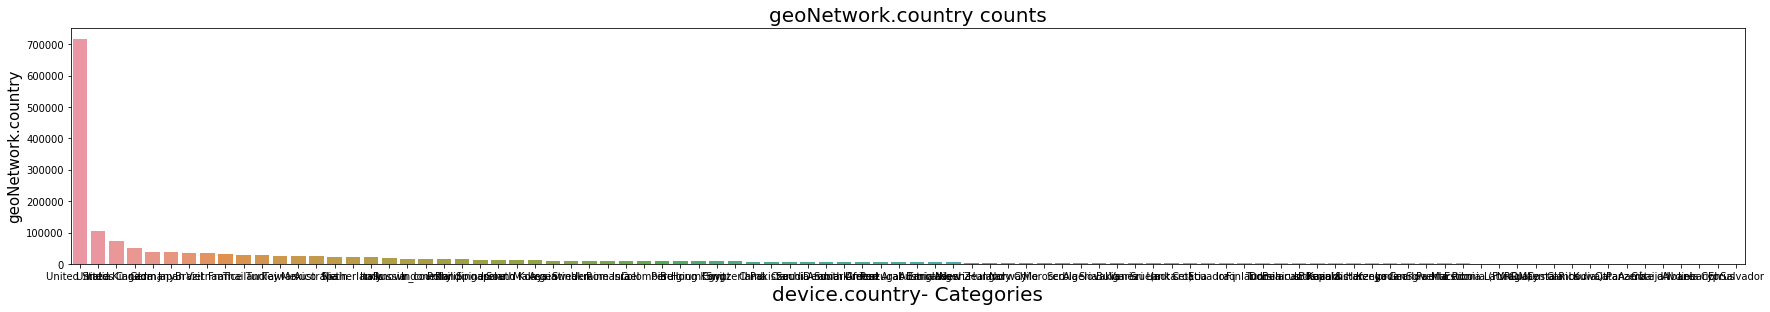

In [47]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('geoNetwork.country counts',fontsize=20)
plt.xlabel('device.country- Categories',fontsize=20)
plt.ylabel('device.country- Category Count',fontsize=15)
sns.barplot(x=train_df['geoNetwork.country'].value_counts().index, y=train_df['geoNetwork.country'].value_counts())

In [48]:
train_df['geoNetwork.country'].value_counts()

United States     717217
India             105317
United Kingdom     73341
Canada             51057
Germany            38516
                   ...  
Côte d’Ivoire        773
Albania              768
Lebanon              743
Cyprus               734
El Salvador          714
Name: geoNetwork.country, Length: 92, dtype: int64

After Pre processing we have about 92 unique values in geoNetwork.country column

geoNetwork.metro

In [49]:
print('There are about {} null values in geoNetwork.metro'.format(train_df['geoNetwork.metro'].isnull().sum()))

There are about 0 null values in geoNetwork.metro


In [50]:
train_df['geoNetwork.metro'].value_counts()

not available in demo dataset        932959
(not set)                            386896
San Francisco-Oakland-San Jose CA    182745
New York NY                           50419
London                                23643
                                      ...  
Des Moines-Ames IA                        6
Tallahassee FL-Thomasville GA             6
Rochester-Mason City-Austin,IA            6
Springfield-Holyoke MA                    6
Buffalo NY                                5
Name: geoNetwork.metro, Length: 123, dtype: int64

We are going to group 'not available in demo dataset' and '(not set)' into 'not available'

In [51]:
train_df['geoNetwork.metro'] = train_df['geoNetwork.metro'].apply(lambda x: 'not available' if ((x == 'not available in demo dataset') or (x == '(not set)')) else x)

In [52]:
train_df['geoNetwork.metro'].value_counts()

not available                         1319855
San Francisco-Oakland-San Jose CA      182745
New York NY                             50419
London                                  23643
Los Angeles CA                          19953
                                       ...   
Champaign & Springfield-Decatur IL          6
Des Moines-Ames IA                          6
Rochester-Mason City-Austin,IA              6
Tallahassee FL-Thomasville GA               6
Buffalo NY                                  5
Name: geoNetwork.metro, Length: 122, dtype: int64

geoNetwork.networkDomain

In [53]:
print('There are about {} null values in geoNetwork.networkDomain'.format(train_df['geoNetwork.networkDomain'].isnull().sum()))

There are about 0 null values in geoNetwork.networkDomain


In [54]:
train_df['geoNetwork.networkDomain'].value_counts()

(not set)                 499049
unknown.unknown           269796
comcast.net                55486
rr.com                     28715
verizon.net                26547
                           ...  
hoxon.com.hk                   1
coppelltx.gov                  1
champlaincollege.qc.ca         1
roma.it                        1
valmar.cl                      1
Name: geoNetwork.networkDomain, Length: 41982, dtype: int64

Almost 700K entries in this feature are (not set) and unknown.unknown. So we are going to drop this feature.

In [55]:
train_df = train_df.drop(['geoNetwork.networkDomain'],axis=1)

geoNetwork.region

In [56]:
train_df['geoNetwork.region'].value_counts()

not available in demo dataset    932959
California                       206669
(not set)                         49774
New York                          49733
England                           25824
                                  ...  
Beni Suef Governorate                 6
Hyogo Prefecture                      6
Apulia                                6
Beirut Governorate                    6
Kumamoto Prefecture                   5
Name: geoNetwork.region, Length: 483, dtype: int64

Almost 100K data entries are 'not available in demo dataset'. So we will be dropping this feature.

In [57]:
train_df = train_df.drop(['geoNetwork.region'],axis=1)

totals.bounces

In [58]:
print(train_df['totals.bounces'].value_counts())

1    871578
Name: totals.bounces, dtype: int64


In [59]:
print('There are about {} null values in totals.bounces'.format(train_df['totals.bounces'].isnull().sum()))

There are about 836759 null values in totals.bounces


In [60]:
print('Since we only have 1.0 and Nans. Even if we consider imputing it with 0s we will get {} 1s and {} 0s.'.format(len(train_df[train_df['totals.bounces']==1]),train_df['totals.bounces'].isnull().sum()))

Since we only have 1.0 and Nans. Even if we consider imputing it with 0s we will get 0 1s and 836759 0s.


In [61]:
train_df['totals.bounces'] = train_df['totals.bounces'].fillna(value=0)

Text(0, 0.5, 'totals.bounces- Category Count')

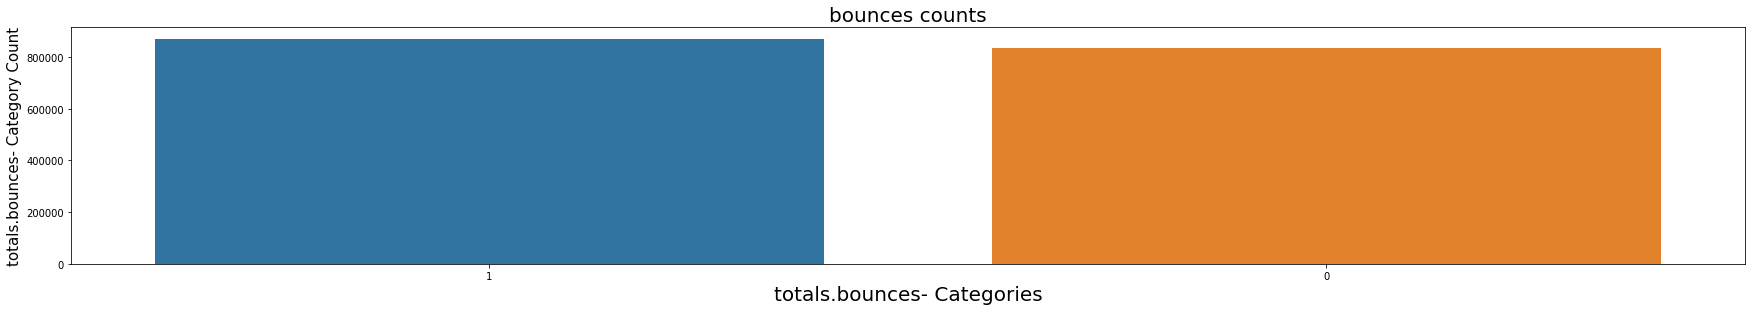

In [62]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('bounces counts',fontsize=20)
sns.barplot(x=train_df['totals.bounces'].value_counts().index, y=train_df['totals.bounces'].value_counts())
plt.xlabel('totals.bounces- Categories',fontsize=20)
plt.ylabel('totals.bounces- Category Count',fontsize=15)


From this scatter plot we can infer that when total.bounces is zero, the totals.transactionRevenue will be much higher when compared to total.bounces is one.

totals.hits

In [63]:
train_df['totals.hits'] = train_df['totals.hits'].astype(int)
train_df['totals.pageviews'] = train_df['totals.pageviews'].fillna(0)
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype(int)

In [64]:
max(train_df['totals.hits'])

500

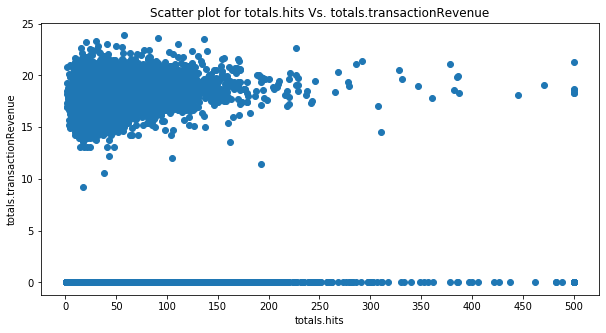

In [65]:
plt.figure(figsize=(10,5))
plt.title('Scatter plot for totals.hits Vs. totals.transactionRevenue')
plt.scatter(x=train_df['totals.hits'],y=np.log1p(train_df['totals.transactionRevenue']))
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) 
plt.xticks(np.arange(0,510,50))
plt.xlabel('totals.hits')
plt.ylabel('totals.transactionRevenue')
plt.savefig('total.hits.png')


totals.newVisits

Assumption(note):

For the columns that were extracted from the original json columns. We dont have column descriptions. But for newVisits column we can infer that one means the user is visting the store for the **first time**. In the data provided we only have 1's populated rest are provided as Nan. So I will be assuming that all the Nan are **zero** since its a **boolean field**. 

In [66]:
print('There are about {} null values in totals.bounces'.format(train_df['totals.newVisits'].isnull().sum()))

There are about 400907 null values in totals.bounces


In [67]:
train_df['totals.newVisits'] = train_df['totals.newVisits'].fillna(value=0)
train_df['totals.newVisits'] = train_df['totals.newVisits'].astype(int)

In [68]:
train_df['totals.newVisits'].value_counts()

1    1307430
0     400907
Name: totals.newVisits, dtype: int64

Text(0, 0.5, 'totals.transactionRevenue')

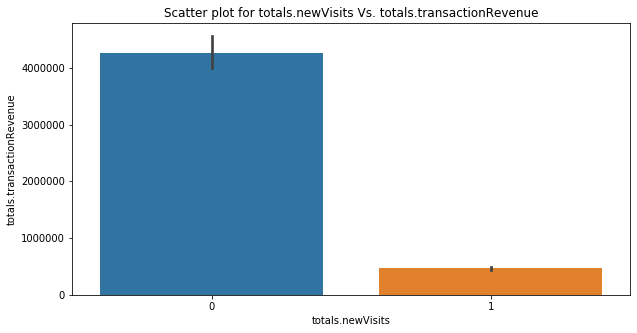

In [69]:
plt.figure(figsize=(10,5))
plt.title('Scatter plot for totals.newVisits Vs. totals.transactionRevenue')
sns.barplot(x=train_df['totals.newVisits'],y=train_df['totals.transactionRevenue'])
plt.xlabel('totals.newVisits')
plt.xticks(np.arange(0,2))
plt.ylabel('totals.transactionRevenue')
# sns.boxplot(x=train_df['totals.transactionRevenue'],y=train_df['totals.newVisits'])


In [70]:
train_df['totals.newVisits'].value_counts()

1    1307430
0     400907
Name: totals.newVisits, dtype: int64

totals.pageviews

Interpretation:
This features represents the numbers of repetative page views that a customer does for a product on the store page. Higher pageviews means higher chance of customer buying the product.

In [71]:
print('There are about {} null values in totals.pageviews'.format(train_df['totals.pageviews'].isnull().sum()))

There are about 0 null values in totals.pageviews


Since the percentage of null values for this column is minuscule, we will be removing all the rows with Nan's.

In [72]:
np.average(train_df['totals.pageviews']>0)

0.9998600978612534

In [73]:
train_df['totals.pageviews'] = train_df['totals.pageviews'].fillna(1)

In [74]:
print('There are about {} null values in totals.pageviews'.format(train_df['totals.pageviews'].isnull().sum()))

There are about 0 null values in totals.pageviews


Text(0, 0.5, 'totals.transactionRevenue')

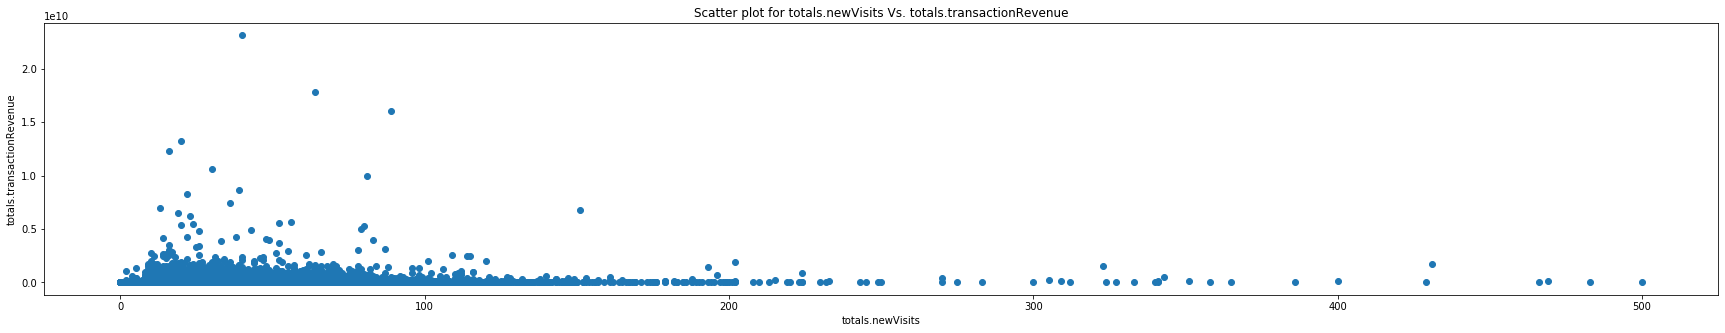

In [75]:
plt.figure(figsize=(30,5))
plt.title('Scatter plot for totals.newVisits Vs. totals.transactionRevenue')
plt.scatter(x=train_df['totals.pageviews'].astype('int'),y=train_df['totals.transactionRevenue'])
plt.xlabel('totals.newVisits')

plt.ylabel('totals.transactionRevenue')
# sns.boxplot(x=train_df['totals.transactionRevenue'],y=train_df['totals.newVisits'])


totals.transactions

In [76]:
print('There are about {} null values in totals.pageviews'.format(train_df['totals.sessionQualityDim'].isnull().sum()))

There are about 835274 null values in totals.pageviews


In [77]:
train_df['totals.transactions'] = train_df['totals.transactions'].fillna(0)
train_df['totals.sessionQualityDim'] = train_df['totals.sessionQualityDim'].fillna(0)
train_df['totals.timeOnSite'] = train_df['totals.timeOnSite'].fillna(0)

trafficSource.adContent

In [78]:
train_df['trafficSource.adContent'].value_counts()

Google Merchandise Store          39566
Google Merchandise Collection      6762
Placement Accessores 300 x 250     3040
Smart display ad - 8/17/2017       2664
Display Ad created 3/11/14         2344
                                  ...  
google store                          2
GA Help Center                        1
Men's Apparel from Google             1
Google Apparel                        1
Swag w/ Google Logos                  1
Name: trafficSource.adContent, Length: 76, dtype: int64

In [79]:
print('There are about {} null values in totals.pageviews \nPercentage of nulls in trafficSource.adContent: {}%'.\
      format(train_df['trafficSource.adContent'].isnull().sum(),round((train_df['trafficSource.adContent'].isnull().sum()*100/len(train_df['trafficSource.adContent'])),2)))

There are about 1643600 null values in totals.pageviews 
Percentage of nulls in trafficSource.adContent: 96.21%


So since we 96% of Nans we will be dropping this column.

In [80]:
train_df = train_df.drop(['trafficSource.adContent'],axis=1)

trafficSource.campaign

In [81]:
train_df['trafficSource.campaign'].value_counts()

(not set)                                                               1604526
Data Share Promo                                                          32914
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS                    24410
1000557 | GA | US | en | Hybrid | GDN Remarketing                         15149
AW - Dynamic Search Ads Whole Site                                        15146
AW - Accessories                                                           7972
Smart Display Campaign                                                     2664
"google + redesign/Accessories March 17" All Users Similar Audiences       1179
Page: contains "/google+redesign/drinkware" Similar Audiences               611
"google + redesign/Accessories March 17" All Users                          562
Sports & Fitness/Health & Fitness Buffs                                     463
Run of Network Line Item                                                    428
Media & Entertainment/Movie Lovers      

In [82]:
print('There are about {} null values in trafficSource.campaign \nPercentage of (not set) in trafficSource.campaign: {}%'.\
      format(len(train_df[train_df['trafficSource.campaign']=='(not set)']),round((len(train_df[train_df['trafficSource.campaign']=='(not set)'])*100/len(train_df['trafficSource.campaign'])),2)))

There are about 1604526 null values in trafficSource.campaign 
Percentage of (not set) in trafficSource.campaign: 93.92%


trafficSource.isTrueDirect

In [83]:
print('There are about {} null values in totals.pageviews \nPercentage of nulls in trafficSource.adContent: {}%'.\
      format(train_df['trafficSource.isTrueDirect'].isnull().sum(),round((train_df['trafficSource.isTrueDirect'].isnull().sum()*100/len(train_df['trafficSource.isTrueDirect'])),2)))

There are about 1173819 null values in totals.pageviews 
Percentage of nulls in trafficSource.adContent: 68.71%


In [84]:
train_df['trafficSource.isTrueDirect'].value_counts()

True    534518
Name: trafficSource.isTrueDirect, dtype: int64

Since the number of Nans is 68% we can eliminate this feature.

In [85]:
train_df = train_df.drop(['trafficSource.isTrueDirect'],axis=1)

trafficSource.keyword

In [86]:
print('There are about {} null values in trafficSource.keyword \nPercentage of nulls in trafficSource.keyword: {}%'.\
      format(train_df['trafficSource.keyword'].isnull().sum(),round((train_df['trafficSource.keyword'].isnull().sum()*100/len(train_df['trafficSource.keyword'])),2)))

There are about 1052780 null values in trafficSource.keyword 
Percentage of nulls in trafficSource.keyword: 61.63%


In [87]:
train_df['trafficSource.keyword'].value_counts()

(not provided)                     568933
(User vertical targeting)           25918
(automatic matching)                18464
6qEhsCssdK0z36ri                    10870
(Remarketing/Content targeting)      5826
                                    ...  
shirts for kids                         1
you tubi                                1
orange and black lava lamp              1
google merch store aus                  1
t-shirts                                1
Name: trafficSource.keyword, Length: 4546, dtype: int64

trafficSource.medium

In [88]:
print('There are about {} null values in trafficSource.medium \nPercentage of nulls in trafficSource.medium: {}%'.\
      format(train_df['trafficSource.medium'].isnull().sum(),round((train_df['trafficSource.medium'].isnull().sum()*100/len(train_df['trafficSource.medium'])),2)))

There are about 0 null values in trafficSource.medium 
Percentage of nulls in trafficSource.medium: 0.0%


In [89]:
train_df['trafficSource.medium'].value_counts()

organic      591783
(none)       565957
referral     432963
cpc           75603
affiliate     32915
cpm            8982
(not set)       134
Name: trafficSource.medium, dtype: int64

Since (none) and (not set) means similar we can group them into a single category.

In [90]:
train_df['trafficSource.medium'] = train_df['trafficSource.medium'].apply(lambda x: '(none)' if x=='(not set)' else x)

In [91]:
train_df['trafficSource.medium'].value_counts()

organic      591783
(none)       566091
referral     432963
cpc           75603
affiliate     32915
cpm            8982
Name: trafficSource.medium, dtype: int64

trafficSource.referralPath

In [92]:
print('There are about {} null values in trafficSource.referralPath \nPercentage of nulls in trafficSource.referralPath: {}%'.\
      format(train_df['trafficSource.referralPath'].isnull().sum(),round((train_df['trafficSource.referralPath'].isnull().sum()*100/len(train_df['trafficSource.referralPath'])),2)))

There are about 1142073 null values in trafficSource.referralPath 
Percentage of nulls in trafficSource.referralPath: 66.85%


In [93]:
train_df['trafficSource.referralPath'].value_counts()

/                                                                                                                                                                    138293
/yt/about/                                                                                                                                                            79163
/analytics/web/                                                                                                                                                       33112
/yt/about/tr/                                                                                                                                                         14600
/yt/about/vi/                                                                                                                                                         13753
                                                                                                                                            

There are 67% of Nans in this feature and even the populated data entires just some random data. So we will be removing this feature.

In [94]:
train_df = train_df.drop(['trafficSource.referralPath'],axis=1)

trafficSource.source

In [95]:
print('There are about {} null values in trafficSource.source \nPercentage of nulls in trafficSource.source: {}%'.\
      format(train_df['trafficSource.source'].isnull().sum(),round((train_df['trafficSource.source'].isnull().sum()*100/len(train_df['trafficSource.source'])),2)))

There are about 0 null values in trafficSource.source 
Percentage of nulls in trafficSource.source: 0.0%


In [96]:
train_df['trafficSource.source'].value_counts().index[:100]

Index(['google', '(direct)', 'youtube.com', 'analytics.google.com', 'Partners',
       'sites.google.com', 'google.com', 'm.facebook.com', 'dfa', 'baidu',
       'reddit.com', 'facebook.com', 'googleads.g.doubleclick.net',
       'qiita.com', 'bing', 'quora.com', 'mail.google.com', 'yahoo',
       'siliconvalley.about.com', 'groups.google.com', 't.co',
       'l.facebook.com', 'blog.golang.org', 'dealspotr.com',
       'support.google.com', 'productforums.google.com', 'plus.google.com',
       'google.co.jp', 'away.vk.com', 'docs.google.com', 'plus.url.google.com',
       'duckduckgo.com', 'sashihara.jp', 'ask', 'optimize.google.com',
       'lunametrics.com', 'phandroid.com', 'google.co.uk',
       'int.search.tb.ask.com', 'm.baidu.com', 's0.2mdn.net',
       'adwords.google.com', 'lm.facebook.com', 'outlook.live.com',
       'seroundtable.com', 'hangouts.google.com', 'online-metrics.com',
       'linkedin.com', 'm.youtube.com', 'l.messenger.com',
       'search.mysearch.com', 'google

as we can see from first 100 entries, we have names of major websites in different domains, we can group these into a single group depending upon the parent domain.

Eg: google and analytics.google.com can be grouped under google or facebook.com and m.facebook.com into a single category.

In [97]:
print('There are about {} unique values in trafficSource.source'.format(len(train_df['trafficSource.source'].value_counts())))

There are about 345 unique values in trafficSource.source


In [98]:
def standardize_traffic_source(val):
    if 'google' in val:
        return 'google'
    elif 'youtube' in val:
        return 'youtube'
    elif 'facebook' in val:
        return 'facebook'
    elif 'yahoo' in val:
        return 'yahoo'
    elif 'baidu' in val:
        return 'baidu'
    elif 'aol' in val:
        return 'aol'
    elif 'quora' in val:
        return 'quora'
    elif 'reddit' in val:
        return 'reddit'
    elif 'pinterest' in val:
        return 'pinterest'
    elif 'bing' in val:
        return 'bing'
    elif 'wow' in val:
        return 'wow'
    elif 'blackboard' in val:
        return 'blackboard'
    elif len(val)>20:
        return 'Other'
    else:
        return val

In [99]:
train_df['trafficSource.source'] = train_df['trafficSource.source'].apply(standardize_traffic_source)

In [100]:
train_df['trafficSource.source']

0            google
1            google
2          (direct)
3            google
4            google
             ...   
1708332     youtube
1708333     youtube
1708334     youtube
1708335    facebook
1708336     youtube
Name: trafficSource.source, Length: 1708337, dtype: object

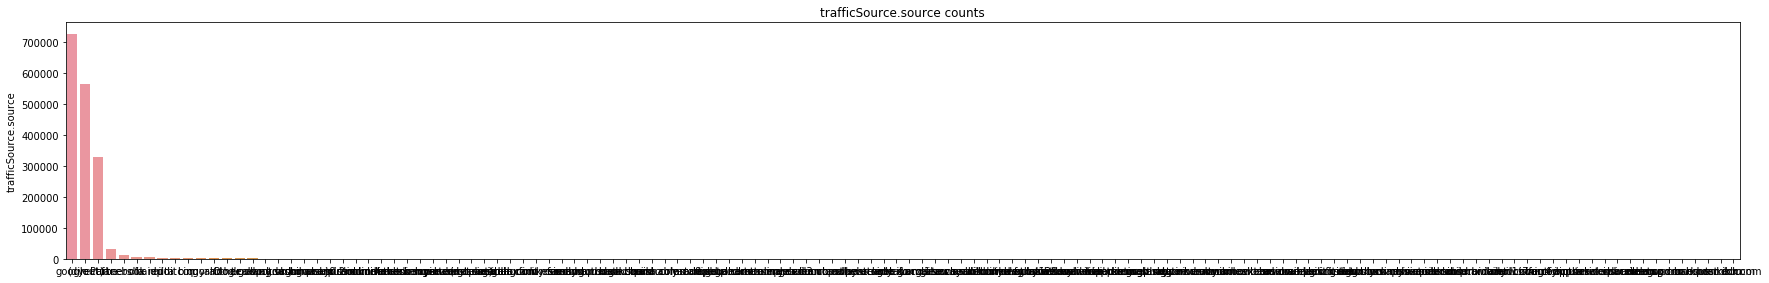

In [101]:
plt.figure(figsize=(30,20))
plt.subplot(4,1,1)
plt.title('trafficSource.source counts')
sns.barplot(x=train_df['trafficSource.source'].value_counts().index, y=train_df['trafficSource.source'].value_counts())

In plot 2 the total numbers of time each city repeates is very less, only 8.0 time a city has been repeated


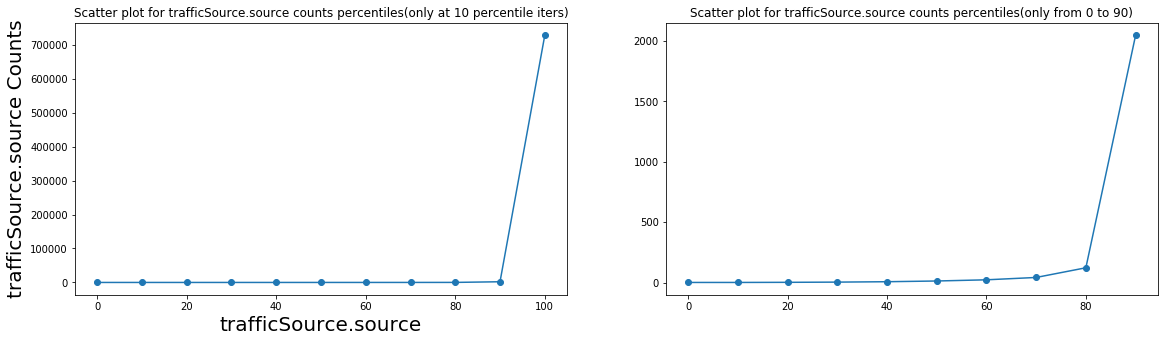

In [102]:
source_value_counts = [i for i in train_df['trafficSource.source'].value_counts()]
percentile = [i for i in range(0,101,10)]
source_percentiles_values = [np.percentile(source_value_counts,per) for per in percentile]
# print(city_percentiles_values)
percentile = [i for i in range(90,101)]
source_ten_percentiles = [np.percentile(source_value_counts,per) for per in percentile]
percentile_numbers = [i for i in range(0,101,10)]
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.title('Scatter plot for trafficSource.source counts percentiles(only at 10 percentile iters)')
plt.scatter(x=percentile_numbers,y=source_percentiles_values)
plt.plot(percentile_numbers,source_percentiles_values)
plt.xlabel('trafficSource.source',fontsize=20)
plt.ylabel('trafficSource.source Counts',fontsize=20)

plt.subplot(1,3,2)
plt.title('Scatter plot for trafficSource.source counts percentiles(only from 0 to 90)')
plt.scatter(x=percentile_numbers[:-1],y=source_percentiles_values[:-1])
plt.plot(percentile_numbers[:-1],source_percentiles_values[:-1])

# plt.xticks([i for i in range(90,100)])
print('In plot {} the total numbers of time each city repeates is very less, only {} time a city has been repeated'.format(2,np.percentile(city_percentiles_values,20)))

As we can see from plot #2 some of the categories repeat vey few times like if you see below 80th percentile. So we will be grouping them into a single category.

In [103]:
np.percentile(source_percentiles_values,80)

122.4

In [104]:
pre_processed_source = []
for source_name,source_count in zip(train_df['trafficSource.source'].value_counts().index,train_df['trafficSource.source'].value_counts()):
  if source_count<(np.percentile(source_percentiles_values,80)):
    pass
  else:
    pre_processed_source.append(source_name)

train_df['trafficSource.source'] = train_df['trafficSource.source'].apply(lambda x: x if x in pre_processed_source else 'unknown_source')

In [105]:
train_df['trafficSource.source'].value_counts()

google                727359
(direct)              565975
youtube               329572
Partners               32931
facebook               12046
dfa                     6704
baidu                   5192
reddit                  4187
qiita.com               3394
bing                    3378
quora                   3032
yahoo                   2905
Other                   2423
t.co                    2005
unknown_source          1922
blog.golang.org         1382
dealspotr.com            750
away.vk.com              613
duckduckgo.com           427
sashihara.jp             424
ask                      417
lunametrics.com          370
phandroid.com            315
s0.2mdn.net              204
outlook.live.com         146
seroundtable.com         140
online-metrics.com       124
Name: trafficSource.source, dtype: int64

After preprocessing we have about 70 categories in 'trafficSource.source'

Year Wise Revenue Plot

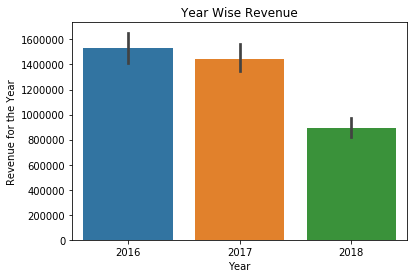

In [106]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
year_wise = train_df.groupby('year')['totals.transactionRevenue'].sum().reset_index()
year_wise = year_wise[year_wise['totals.transactionRevenue']>0]

year_plot = sns.barplot(x=train_df['year'], y=train_df['totals.transactionRevenue'], data=train_df)
year_plot.set(xlabel='Year',ylabel='Revenue for the Year')
year_plot.set(title='Year Wise Revenue')
plt.savefig('Final_plots\year.png')

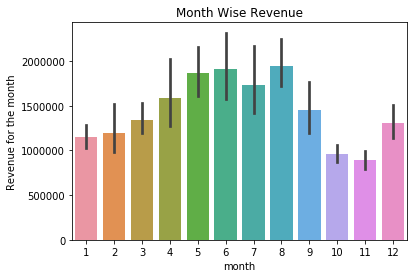

In [107]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
month_wise = train_df.groupby('month')['totals.transactionRevenue'].sum().reset_index()
month_wise = month_wise[month_wise['totals.transactionRevenue']>0]

month_plot = sns.barplot(x=train_df['month'], y=train_df['totals.transactionRevenue'], data=train_df)
month_plot.set(xlabel='month',ylabel='Revenue for the month')
month_plot.set(title='Month Wise Revenue')
plt.savefig('Final_plots\month.png')

As we can see the revenue is generated through out the year but its considerabily less in the last three months of the year

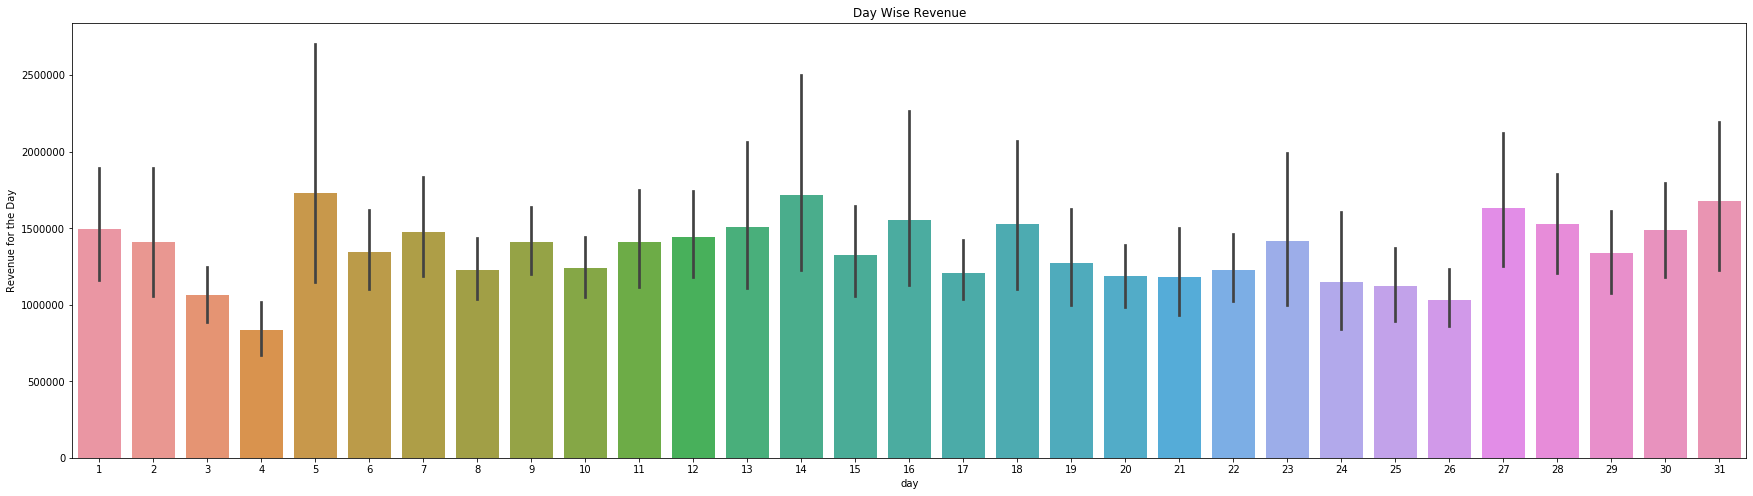

In [108]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
day_wise = train_df.groupby('day')['totals.transactionRevenue'].sum().reset_index()
day_wise = day_wise[day_wise['totals.transactionRevenue']>0]
plt.figure(figsize=(30,8))
day_plot = sns.barplot(x=train_df['day'], y=train_df['totals.transactionRevenue'], data=train_df)
day_plot.set(xlabel='day',ylabel='Revenue for the Day')
day_plot.set(title='Day Wise Revenue')
plt.savefig('Final_plots\day.png')

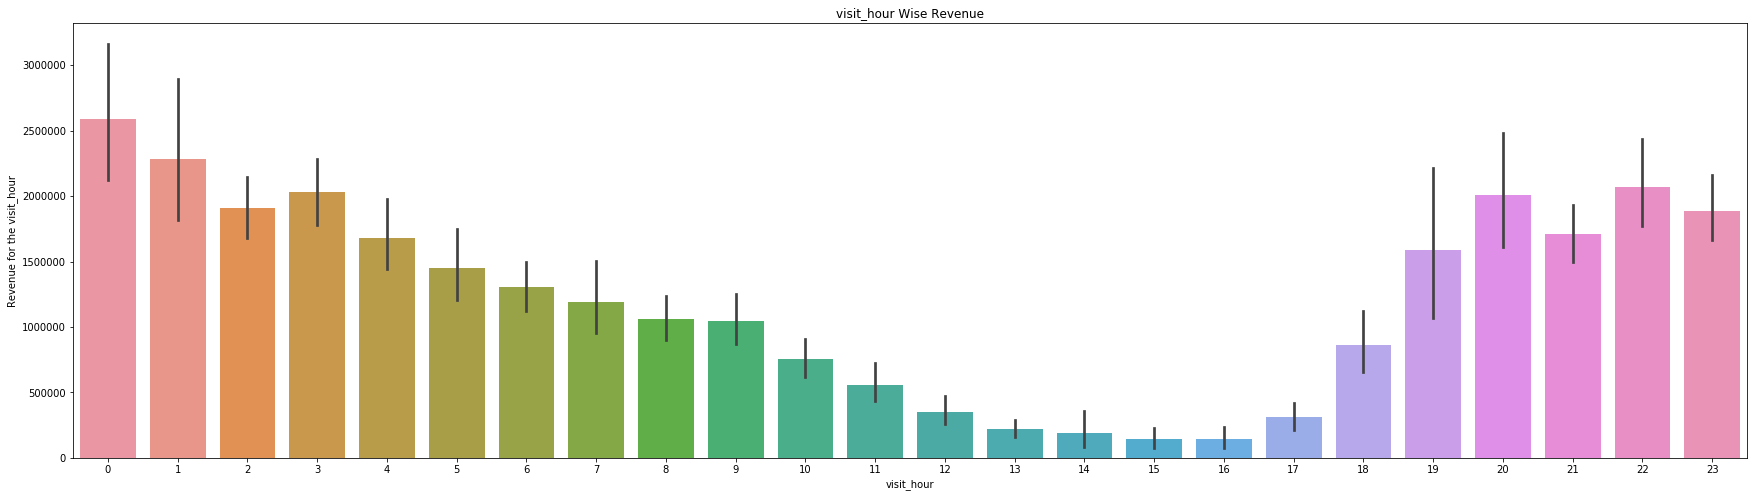

In [109]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
visit_hour_wise = train_df.groupby('visit_hour')['totals.transactionRevenue'].sum().reset_index()
visit_hour_wise = visit_hour_wise[visit_hour_wise['totals.transactionRevenue']>0]
plt.figure(figsize=(30,8))
visit_hour_plot = sns.barplot(x=train_df['visit_hour'], y=train_df['totals.transactionRevenue'], data=train_df)
visit_hour_plot.set(xlabel='visit_hour',ylabel='Revenue for the visit_hour')
visit_hour_plot.set(title='visit_hour Wise Revenue')
plt.savefig('time.png')

As we can see from the plot most shopping activity is happening after 17:00 hrs(i.e 5 PM). This can be a good indicator for revenue prediction.

There are some features that are not usefull like the one which has ID's. fullVisitorId, visitId visitStartTime(hours has been extracted)and date(this has been divided into date,month,year)

In [110]:
train_df = train_df.drop(['date','visitStartTime','fullVisitorId','visitId'],axis=1)

In [111]:
train_df

,channelGrouping,visitNumber,socialEngagementType,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.sessionQualityDim,totals.transactions,totals.timeOnSite,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,year,month,day,visit_hour
0,Organic Search,1,Not Socially Engaged,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available,Western Europe,1,1,1,1,0.0,1,0,0,(not set),water bottle,organic,google,2017,10,16,5
1,Referral,6,Not Socially Engaged,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,Northern America,0,2,0,2,0.0,2,0,28,(not set),NaN,referral,google,2017,10,16,23
2,Direct,1,Not Socially Engaged,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available,Northern America,0,2,1,2,0.0,1,0,38,(not set),NaN,(none),(direct),2017,10,16,6
3,Organic Search,1,Not Socially Engaged,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available,Western Asia,0,2,1,2,0.0,1,0,1,(not set),(not provided),organic,google,2017,10,16,21
4,Organic Search,1,Not Socially Engaged,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available,Central America,0,2,1,2,0.0,1,0,52,(not set),(not provided),organic,google,2017,10,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,1,Not Socially Engaged,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Puerto Rico,not available,Caribbean,0,17,1,15,0.0,0,0,626,(not set),NaN,referral,youtube,2017,1,4,0
1708333,Social,1,Not Socially Engaged,Chrome,mobile,True,Android,not available in demo dataset,Asia,Sri Lanka,not available,Southern Asia,0,18,1,13,0.0,0,0,258,(not set),NaN,referral,youtube,2017,1,4,20
1708334,Social,1,Not Socially Engaged,Android Webview,mobile,True,Android,Seoul,Asia,South Korea,not available,Eastern Asia,0,24,1,21,0.0,0,0,991,(not set),NaN,referral,youtube,2017,1,4,16
1708335,Social,1,Not Socially Engaged,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Indonesia,not available,Southeast Asia,0,24,1,22,0.0,0,0,1274,(not set),NaN,referral,facebook,2017,1,4,10


Data Preprocessing

In [112]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [123]:
import pandas as pd
import json
from json import loads,dumps
from pandas.io.json import json_normalize
import os
from tqdm import tqdm
import gc
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 500)
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder  
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score
import lightgbm as lgb 


In [114]:
if not os.path.isfile('train_df_without_json.pkl'):
    train_df = load_df(csv_path='train_v2.csv')
    train_df.to_pickle('train_df_without_json.pkl')
else:
    train_df = pd.read_pickle('train_df_without_json.pkl')


In [115]:
if not os.path.isfile('test_df_without_json.pkl'):
    test_df = load_df(csv_path='test_v2.csv')
    test_df.to_pickle('test_df_without_json.pkl')
else:
    test_df = pd.read_pickle('test_df_without_json.pkl')


In [116]:
test_df

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,socialEngagementType,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,totals.sessionQualityDim,totals.transactions,totals.timeOnSite,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,year,month,day,visit_hour
0,Organic Search,2018-05-11,7460955084541987166,1526099341,2,1526099341,Not Socially Engaged,Chrome,mobile,True,Android,(not set),Asia,India,(not set),unknown.unknown,Delhi,Southern Asia,NaN,4,NaN,3,NaN,(not set),1,NaN,973,(not set),True,(not provided),organic,(not set),google,2018,5,11,9
1,Direct,2018-05-11,460252456180441002,1526064483,166,1526064483,Not Socially Engaged,Chrome,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,4,NaN,3,NaN,(not set),1,NaN,49,(not set),True,(not set),(none),(not set),(direct),2018,5,11,0
2,Organic Search,2018-05-11,3461808543879602873,1526067157,2,1526067157,Not Socially Engaged,Chrome,desktop,False,Chrome OS,not available in demo dataset,Americas,United States,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,Northern America,NaN,4,NaN,3,NaN,(not set),1,NaN,24,(not set),True,(not provided),organic,(not set),google,2018,5,11,1
3,Direct,2018-05-11,975129477712150630,1526107551,4,1526107551,Not Socially Engaged,Chrome,mobile,True,iOS,Houston,Americas,United States,Houston TX,(not set),Texas,Northern America,NaN,5,NaN,4,NaN,(not set),1,NaN,25,(not set),True,(not set),(none),(not set),(direct),2018,5,11,12
4,Organic Search,2018-05-11,8381672768065729990,1526060254,1,1526060254,Not Socially Engaged,Internet Explorer,tablet,True,Windows,Irvine,Americas,United States,Los Angeles CA,com,California,Northern America,NaN,5,1,4,NaN,(not set),1,NaN,49,(not set),NaN,(not provided),organic,(not set),google,2018,5,11,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,Organic Search,2018-09-07,6701149525099562370,1536353803,1,1536353803,Not Socially Engaged,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,(not set),not available in demo dataset,Northern Europe,NaN,3,1,3,NaN,(not set),1,NaN,111,(not set),NaN,(not provided),organic,(not set),google,2018,9,7,2
401585,Organic Search,2018-09-07,6154541330147351453,1536388075,1,1536388075,Not Socially Engaged,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,NaN,3,1,3,NaN,(not set),1,NaN,10,(not set),NaN,(not provided),organic,(not set),google,2018,9,7,11
401586,Organic Search,2018-09-07,6013469762773705448,1536351791,3,1536351791,Not Socially Engaged,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Greece,not available in demo dataset,(not set),not available in demo dataset,Southern Europe,NaN,3,NaN,3,NaN,(not set),1,NaN,63,(not set),True,(not provided),organic,(not set),google,2018,9,7,1
401587,Organic Search,2018-09-07,4565378823441900999,1536340217,1,1536340217,Not Socially Engaged,Chrome,desktop,False,Chrome OS,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,NaN,3,1,3,NaN,(not set),1,NaN,64,(not set),NaN,(not provided),organic,(not set),google,2018,9,7,22


In [117]:
train_test_df = pd.concat([train_df,test_df],axis=0)

In [118]:
train_test_df['totals.bounces'] = train_test_df['totals.bounces'].fillna(0)
train_test_df['totals.bounces'] = train_test_df['totals.bounces'].apply(lambda x: str(x))

In [119]:
import re
def standardize_traffic_keyword(keyword):
    keyword=str(keyword).lower()
    if 'goo' in keyword or 'stor' in keyword:
        return 'google'
    elif 'yo' in keyword or 'yuotub' in keyword or 'yuo tub' in keyword or 'tub' in keyword or 'yutob' in keyword:
        return 'youtube'
    elif 'tshirt' in keyword or 't shirt' in keyword or 't-shirt' in keyword:
        return 'tshirt'
    elif 'shirts' in keyword or 'shirt' in keyword:
        return 'shirts'
    elif 'lamp' in keyword or 'lamps' in keyword:
        return 'lamps'
    elif 'android' in keyword:
        return 'android'
    elif 'merchandi' in keyword:
        return 'merchandise'
    elif bool(re.search(r'\d', keyword)):
        return 'other'
    elif 'apparel' in keyword:
        return 'apparel'
    elif len(keyword)>28:
        return 'other'
    else:
        return keyword

In [120]:
def standardize_traffic_source(val):
    if 'google' in val:
        return 'google'
    elif 'youtube' in val:
        return 'youtube'
    elif 'facebook' in val:
        return 'facebook'
    elif 'yahoo' in val:
        return 'yahoo'
    elif 'baidu' in val:
        return 'baidu'
    elif 'aol' in val:
        return 'aol'
    elif 'quora' in val:
        return 'quora'
    elif 'reddit' in val:
        return 'reddit'
    elif 'pinterest' in val:
        return 'pinterest'
    elif 'bing' in val:
        return 'bing'
    elif 'wow' in val:
        return 'wow'
    elif 'blackboard' in val:
        return 'blackboard'
    elif len(val)>20:
        return 'Other'
    else:
        return val

In [124]:
def preprocessig(dataframe):
  dataframe['totals.transactionRevenue'] = dataframe['totals.transactionRevenue'].fillna(0)
  dataframe['totals.transactionRevenue'] = dataframe['totals.transactionRevenue'].apply(lambda x:float(x))
  dataframe['fullVisitorId'] = dataframe['fullVisitorId'].apply(lambda x: str(x))
  dataframe['totals.hits'] = dataframe['totals.hits'].astype(int)

  dataframe['totals.pageviews'] = dataframe['totals.pageviews'].fillna(0)
  dataframe['totals.pageviews'] = dataframe['totals.pageviews'].astype(int)

  dataframe['totals.sessionQualityDim'] = dataframe['totals.sessionQualityDim'].fillna(0)
  dataframe['totals.sessionQualityDim'] = dataframe['totals.sessionQualityDim'].astype(int)
  
  dataframe['totals.transactions'] = dataframe['totals.transactions'].fillna(0)
  dataframe['totals.transactions'] = dataframe['totals.transactions'].astype(int)

  dataframe['totals.timeOnSite'] = dataframe['totals.timeOnSite'].fillna(0)
  dataframe['totals.timeOnSite'] = dataframe['totals.timeOnSite'].astype(int)


  dataframe['totals.transactionRevenue'] = dataframe['totals.transactionRevenue'].fillna(0)
  dataframe['totals.transactions'] = dataframe['totals.transactions'].fillna(0)

  drop_cols = ['trafficSource.adContent', 'visitId', 'device.isMobile', 'trafficSource.referralPath','visitNumber', 'visitStartTime','totals.newVisits','socialEngagementType','trafficSource.isTrueDirect']
  dataframe = dataframe.drop(drop_cols,axis=1)

  # Preprocessing device.browser col
  popular_browsers = ['Chrome','Safari','Firefox','Internet Explorer','Android Webview','Edge','Samsung Internet','Opera Mini','Safari (in-app)','Opera']

  dataframe['device.browser'] = dataframe['device.browser'].apply(lambda x: x if x in popular_browsers else 'unpopular_browser')
  train_df['device.browser'] = train_df['device.browser'].apply(lambda x: x if x in popular_browsers else 'unpopular_browser')

  # Preprocessing device.operatingsystem col
  operating_systems = ['Windows','Macintosh','Android','iOS','Linux','Chrome OS']
  dataframe['device.operatingSystem'] = dataframe['device.operatingSystem'].apply(lambda x:x if x in operating_systems else 'Generic_OS') 
  train_df['device.operatingSystem'] = train_df['device.operatingSystem'].apply(lambda x:x if x in operating_systems else 'Generic_OS') 

  # Preprocessing geoNetwork.city col

  geo_city_value_counts = [i for i in train_df['geoNetwork.city'].value_counts()]
  percentile = [i for i in range(0,101,10)]
  city_percentiles_values = [np.percentile(geo_city_value_counts,per) for per in percentile]

  pre_processed_cities = []
  for city_name,city_count in zip(train_df['geoNetwork.city'].value_counts().index,train_df['geoNetwork.city'].value_counts()):
    if city_count<(np.percentile(city_percentiles_values,90)):
      pass
    else:
      pre_processed_cities.append(city_name)

  dataframe['geoNetwork.city'] = dataframe['geoNetwork.city'].apply(lambda x: x if x in pre_processed_cities else 'unknown_city')
  train_df['geoNetwork.city'] = train_df['geoNetwork.city'].apply(lambda x: x if x in pre_processed_cities else 'unknown_city')

  geo_country_value_counts = [i for i in train_df['geoNetwork.country'].value_counts()]
  country_percentiles_values = [np.percentile(geo_country_value_counts,per) for per in percentile]

  pre_processed_country = []
  for country_name,country_count in zip(train_df['geoNetwork.country'].value_counts().index,train_df['geoNetwork.country'].value_counts()):
    if country_count<(np.percentile(country_percentiles_values,60)):
      pass
    else:
      pre_processed_country.append(country_name)

  dataframe['geoNetwork.country'] = dataframe['geoNetwork.country'].apply(lambda x: x if x in pre_processed_country else 'unknown_country')
  train_df['geoNetwork.country'] = train_df['geoNetwork.country'].apply(lambda x: x if x in pre_processed_country else 'unknown_country')

  dataframe['geoNetwork.metro'] = dataframe['geoNetwork.metro'].apply(lambda x: 'not available' if ((x == 'not available in demo dataset') or (x == '(not set)')) else x)
  train_df['geoNetwork.metro'] = train_df['geoNetwork.metro'].apply(lambda x: 'not available' if ((x == 'not available in demo dataset') or (x == '(not set)')) else x)

  dataframe['totals.bounces'] = dataframe['totals.bounces'].fillna(value=0)
  train_df['totals.bounces'] = train_df['totals.bounces'].fillna(value=0)

  dataframe['trafficSource.keyword'] = dataframe['trafficSource.keyword'].fillna('other')
  dataframe['trafficSource.keyword'] = dataframe['trafficSource.keyword'].apply(standardize_traffic_keyword)
  train_df['trafficSource.keyword'] = train_df['trafficSource.keyword'].fillna('other')
  train_df['trafficSource.keyword'] = train_df['trafficSource.keyword'].apply(standardize_traffic_keyword)

  dataframe['trafficSource.source'] = dataframe['trafficSource.source'].apply(standardize_traffic_source)
  train_df['trafficSource.source'] = train_df['trafficSource.source'].apply(standardize_traffic_source)

  categorical_features = ['channelGrouping','device.browser','device.deviceCategory','device.operatingSystem','geoNetwork.city','geoNetwork.continent',\
                          'geoNetwork.country','geoNetwork.metro','geoNetwork.networkDomain','geoNetwork.region','geoNetwork.subContinent','totals.bounces',\
                          'trafficSource.campaign','trafficSource.keyword','trafficSource.medium','trafficSource.source']

  for feature in tqdm(train_df[categorical_features].columns):
  # encoded_feature = feature + '_encoded'
    encode = LabelEncoder()
    encode.fit(dataframe[feature])
    dataframe[feature] = encode.transform(dataframe[feature])
  return dataframe

In [125]:
train_test_df_preprocessed = preprocessig(train_test_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


In [126]:
overall_period = pd.date_range(start='2016-08-01',end='2018-12-01', freq='2MS')  #Catch the start-date of every alternate month from Aug-1st-2016 to Dec-1st-2018
train_period = overall_period.to_series().shift(periods=-220, freq='d',axis= 0)  #Shift the index of 'overall_period' by -220 days (will be used for features of dataset)
time_from = train_period[train_period.index>np.datetime64('2016-08-01')]         #Select only those values where index > Aug-2016
time_end = overall_period.to_series().shift(periods=-50, freq='d',axis= 0)[4:]   #Shift the index of 'overall_period' by only -50 days (will be used for target variable of dataset)


In [127]:
overall_period

DatetimeIndex(['2016-08-01', '2016-10-01', '2016-12-01', '2017-02-01',
               '2017-04-01', '2017-06-01', '2017-08-01', '2017-10-01',
               '2017-12-01', '2018-02-01', '2018-04-01', '2018-06-01',
               '2018-08-01', '2018-10-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='2MS')

In [128]:
train_period

2015-12-25   2016-08-01
2016-02-24   2016-10-01
2016-04-25   2016-12-01
2016-06-26   2017-02-01
2016-08-24   2017-04-01
2016-10-24   2017-06-01
2016-12-24   2017-08-01
2017-02-23   2017-10-01
2017-04-25   2017-12-01
2017-06-26   2018-02-01
2017-08-24   2018-04-01
2017-10-24   2018-06-01
2017-12-24   2018-08-01
2018-02-23   2018-10-01
2018-04-25   2018-12-01
dtype: datetime64[ns]

In [129]:
time_from

2016-08-24   2017-04-01
2016-10-24   2017-06-01
2016-12-24   2017-08-01
2017-02-23   2017-10-01
2017-04-25   2017-12-01
2017-06-26   2018-02-01
2017-08-24   2018-04-01
2017-10-24   2018-06-01
2017-12-24   2018-08-01
2018-02-23   2018-10-01
2018-04-25   2018-12-01
dtype: datetime64[ns]

In [130]:
time_end

2017-02-10   2017-04-01
2017-04-12   2017-06-01
2017-06-12   2017-08-01
2017-08-12   2017-10-01
2017-10-12   2017-12-01
2017-12-13   2018-02-01
2018-02-10   2018-04-01
2018-04-12   2018-06-01
2018-06-12   2018-08-01
2018-08-12   2018-10-01
2018-10-12   2018-12-01
dtype: datetime64[ns]

In [131]:
def aggregator(dataframe,i,for_test):

  if not for_test:
    feature_df = dataframe[(pd.to_datetime(dataframe['date']) > time_from.index[i]) & (pd.to_datetime(dataframe['date']) <= time_end.index[i])].copy()
  else:
    feature_df = dataframe
  features_to_drop = ['totals.bounces']
  median_features = ['device.browser', 'device.deviceCategory','device.operatingSystem','geoNetwork.city','geoNetwork.continent','geoNetwork.country','geoNetwork.subContinent','trafficSource.medium','trafficSource.source']

  sum_features = ['totals.hits','totals.pageviews','totals.sessionQualityDim','totals.transactions','totals.timeOnSite']

  mean_feature = ['year','month','day','visit_hour']

  feature_df = feature_df.drop(features_to_drop,axis=1)
  final_dataframe = pd.concat([feature_df.groupby('fullVisitorId')[median_features].median().add_suffix('.median'),
                              feature_df.groupby('fullVisitorId')[sum_features].sum().add_suffix('.sum'),
                              feature_df.groupby('fullVisitorId')[mean_feature].mean().add_suffix('.mean')
                              ],axis=1).reset_index()

  # preparing future target for current time line
  if not for_test:
    target_df = dataframe[(pd.to_datetime(dataframe['date']) > pd.Timestamp(time_from.values[i])) & (pd.to_datetime(dataframe['date']) <= pd.Timestamp(time_end.values[i+1]))].copy()      
    target_df['fullVisitorId'] = target_df['fullVisitorId'].apply(lambda x: str(x))
  # Merging x dataframe with target data for each fullvisitorID

    final_dataframe = final_dataframe.merge(target_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum(),how = 'left',on = 'fullVisitorId')
  

    final_dataframe['totals.transactionRevenue'] = np.log1p(final_dataframe['totals.transactionRevenue'])
    final_dataframe['totals.transactionRevenue'] = final_dataframe['totals.transactionRevenue'].apply( lambda x: x if x>=0 else 0)

  return final_dataframe

In [132]:
# taking validation from the entire data

validation = aggregator(train_test_df_preprocessed,i=5,for_test=False)
validation_y = validation['totals.transactionRevenue']
validation_x = validation.drop(['fullVisitorId','totals.transactionRevenue'],axis=1)

In [133]:
validation_x

,device.browser.median,device.deviceCategory.median,device.operatingSystem.median,geoNetwork.city.median,geoNetwork.continent.median,geoNetwork.country.median,geoNetwork.subContinent.median,trafficSource.medium.median,trafficSource.source.median,totals.hits.sum,totals.pageviews.sum,totals.sessionQualityDim.sum,totals.transactions.sum,totals.timeOnSite.sum,year.mean,month.mean,day.mean,visit_hour.mean
0,1.0,0.0,4.0,3.0,2.0,34.0,12.0,5.0,52.0,19,13,12,0,129,2017.0,11.0,28.000000,5.000000
1,1.0,0.0,1.0,9.0,3.0,10.0,18.0,0.0,0.0,3,3,3,0,0,2017.0,9.0,18.333333,6.666667
2,1.0,0.0,5.0,8.0,2.0,3.0,15.0,2.0,3.0,1,1,1,0,0,2017.0,7.0,9.000000,5.000000
3,7.0,1.0,6.0,9.0,2.0,34.0,12.0,0.0,0.0,1,1,1,0,0,2017.0,7.0,19.000000,4.000000
4,7.0,0.0,4.0,5.0,2.0,34.0,12.0,5.0,52.0,2,2,1,0,13,2017.0,9.0,8.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388390,1.0,1.0,0.0,9.0,2.0,34.0,12.0,0.0,0.0,1,1,1,0,0,2017.0,12.0,13.000000,20.000000
388391,3.0,0.0,5.0,9.0,5.0,1.0,1.0,6.0,140.0,10,9,1,0,231,2017.0,10.0,11.000000,9.000000
388392,1.0,0.0,4.0,9.0,2.0,34.0,12.0,5.0,52.0,2,2,1,0,17,2017.0,8.0,3.000000,3.000000
388393,1.0,0.0,5.0,9.0,3.0,10.0,18.0,5.0,52.0,1,1,0,0,0,2017.0,7.0,1.000000,14.000000


In [134]:
test_df = train_test_df_preprocessed.iloc[train_df.shape[0]:,:].copy()
final_test_df = aggregator(test_df,i=0,for_test=True)
submission_ids = final_test_df['fullVisitorId']
final_test_df_x = final_test_df.drop(['fullVisitorId'],axis=1)


In [135]:
submission_ids.nunique()

296530

In [136]:
submission_catboost_preds = np.zeros(len(final_test_df_x))
submission_xgb_preds = np.zeros(len(final_test_df_x))
submission_lgb_preds = np.zeros(len(final_test_df_x))


In [137]:
validation_x

,device.browser.median,device.deviceCategory.median,device.operatingSystem.median,geoNetwork.city.median,geoNetwork.continent.median,geoNetwork.country.median,geoNetwork.subContinent.median,trafficSource.medium.median,trafficSource.source.median,totals.hits.sum,totals.pageviews.sum,totals.sessionQualityDim.sum,totals.transactions.sum,totals.timeOnSite.sum,year.mean,month.mean,day.mean,visit_hour.mean
0,1.0,0.0,4.0,3.0,2.0,34.0,12.0,5.0,52.0,19,13,12,0,129,2017.0,11.0,28.000000,5.000000
1,1.0,0.0,1.0,9.0,3.0,10.0,18.0,0.0,0.0,3,3,3,0,0,2017.0,9.0,18.333333,6.666667
2,1.0,0.0,5.0,8.0,2.0,3.0,15.0,2.0,3.0,1,1,1,0,0,2017.0,7.0,9.000000,5.000000
3,7.0,1.0,6.0,9.0,2.0,34.0,12.0,0.0,0.0,1,1,1,0,0,2017.0,7.0,19.000000,4.000000
4,7.0,0.0,4.0,5.0,2.0,34.0,12.0,5.0,52.0,2,2,1,0,13,2017.0,9.0,8.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388390,1.0,1.0,0.0,9.0,2.0,34.0,12.0,0.0,0.0,1,1,1,0,0,2017.0,12.0,13.000000,20.000000
388391,3.0,0.0,5.0,9.0,5.0,1.0,1.0,6.0,140.0,10,9,1,0,231,2017.0,10.0,11.000000,9.000000
388392,1.0,0.0,4.0,9.0,2.0,34.0,12.0,5.0,52.0,2,2,1,0,17,2017.0,8.0,3.000000,3.000000
388393,1.0,0.0,5.0,9.0,3.0,10.0,18.0,5.0,52.0,1,1,0,0,0,2017.0,7.0,1.000000,14.000000


Only catboost

In [142]:
kfold=list(range(time_from.shape[0]-1))
kfold.remove(5)
for fold in kfold:
    fold_df = aggregator(train_test_df_preprocessed, fold,for_test=False)
    train_y = fold_df['totals.transactionRevenue']
    train_x = fold_df.copy().drop(['fullVisitorId','totals.transactionRevenue'],inplace=False,axis=1)
    print('\n{} {}.1) CREATED TRAIN SET OF <{}> FOR THIS FOLD {}'.format(26*'#', fold, train_x.shape, 26*'#'))
    
    try:
        del(fold_df)
    except:
        pass
    
    print('\n{} {}.2) TRAINING CatBoostRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    catboost = CatBoostRegressor(iterations=1100,learning_rate=0.04, depth=10, bagging_temperature = 0.2, od_wait=20,
                                 eval_metric='RMSE', random_seed=0, od_type='Iter')
    scalar = MinMaxScaler()
    scalar.fit(train_x)
    train_x = scalar.transform(train_x)
    validation_x = scalar.transform(validation_x)
    final_test_df_x = scalar.transform(final_test_df_x)
    catboost.fit(train_x , train_y, eval_set=[(validation_x, validation_y)],early_stopping_rounds=100, use_best_model=True, verbose=100)
    
    predictions = catboost.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.3) CATBOOST REGRESSION LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))
    submission_preds_raw=catboost.predict(final_test_df_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_catboost_preds += submission_preds_raw / len(kfold)


########################## 0.1) CREATED TRAIN SET OF <(376718, 18)> FOR THIS FOLD ##########################

########################## 0.2) TRAINING CatBoostRegressor FOR THIS FOLD ##########################
0:	learn: 0.3533211	test: 0.3183434	best: 0.3183434 (0)	total: 108ms	remaining: 1m 58s
100:	learn: 0.3191976	test: 0.3424773	best: 0.3183421 (11)	total: 10.5s	remaining: 1m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3183421344
bestIteration = 11

Shrink model to first 12 iterations.
>>>>>>>>>>>>>>>>>>>>>>>>>>0.3) CATBOOST REGRESSION LOSS = 0.3183421363151852<<<<<<<<<<<<<<<<<<<<<<<<<<



########################## 1.1) CREATED TRAIN SET OF <(357916, 18)> FOR THIS FOLD ##########################

########################## 1.2) TRAINING CatBoostRegressor FOR THIS FOLD ##########################
0:	learn: 0.3122605	test: 0.3183424	best: 0.3183424 (0)	total: 106ms	remaining: 1m 55s
100:	learn: 0.2919803	test: 0.3184035	best: 0.3183424 (0)	total: 9.34s	r

In [143]:
submissions_df = pd.DataFrame()
submissions_df['fullVisitorId'] = submission_ids
submissions_df['fullVisitorId'] = submissions_df['fullVisitorId'].astype(str)
submissions_df['PredictedLogRevenue'] = submission_catboost_preds

In [144]:
submissions_df.to_csv('results\My_testing_2_catboost.csv',index=False)

In [152]:
submission_catboost_preds = np.zeros(len(final_test_df_x))
submission_xgb_preds = np.zeros(len(final_test_df_x))
submission_lgb_preds = np.zeros(len(final_test_df_x))


Only xgboost regressor

In [154]:
kfold=list(range(time_from.shape[0]-1))
kfold.remove(5)
for fold in kfold:
    fold_df = aggregator(train_test_df_preprocessed, fold,for_test=False)
    train_y = fold_df['totals.transactionRevenue']
    train_x = fold_df.copy().drop(['fullVisitorId','totals.transactionRevenue'],inplace=False,axis=1)
    print('\n{} {}.1) CREATED TRAIN SET OF <{}> FOR THIS FOLD {}'.format(26*'#', fold, train_x.shape, 26*'#'))
    
    try:
        del(fold_df)
    except:
        pass

    scalar = MinMaxScaler()
    scalar.fit(train_x)
    train_x = scalar.transform(train_x)
    validation_x = scalar.transform(validation_x)
    final_test_df_x = scalar.transform(final_test_df_x)

    print('\n{} {}.4) TRAINING XGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    xgb = XGBRegressor(n_estimators=1000, max_depth=20, learning_rate=0.07, booster='gbtree', random_state=0, importance_type='total_gain',
                       objective= 'reg:squarederror', gamma=1.45, alpha=0.0, subsample=0.67, colsample_bytree=0.054, colsample_bylevel= 0.50)
    xgb.fit(train_x , train_y ,eval_set=[(validation_x, validation_y)], early_stopping_rounds=100, eval_metric='rmse', verbose=100)
    predictions = xgb.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.5) XGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))

    submission_preds_raw=xgb.predict(final_test_df_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_xgb_preds +=  submission_preds_raw / len(kfold)


########################## 0.1) CREATED TRAIN SET OF <(376718, 18)> FOR THIS FOLD ##########################

########################## 0.4) TRAINING XGBRegressor FOR THIS FOLD ##########################
[0]	validation_0-rmse:0.55874
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.31832
Stopping. Best iteration:
[67]	validation_0-rmse:0.31828

>>>>>>>>>>>>>>>>>>>>>>>>>>0.5) XGB LOSS = 0.31834895040068817<<<<<<<<<<<<<<<<<<<<<<<<<<



########################## 1.1) CREATED TRAIN SET OF <(357916, 18)> FOR THIS FOLD ##########################

########################## 1.4) TRAINING XGBRegressor FOR THIS FOLD ##########################
[0]	validation_0-rmse:0.55875
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.31847
Stopping. Best iteration:
[53]	validation_0-rmse:0.31828

>>>>>>>>>>>>>>>>>>>>>>>>>>1.5) XGB LOSS = 0.3183485393102688<<<<<<<<<<<<<<<<<<<<<<<<<<



########################## 2.1) CREA

In [155]:
submissions_df = pd.DataFrame()
submissions_df['fullVisitorId'] = submission_ids
submissions_df['fullVisitorId'] = submissions_df['fullVisitorId'].astype(str)
submissions_df['PredictedLogRevenue'] = submission_xgb_preds

In [156]:
submissions_df.to_csv('results\My_testing_2_xgboost.csv',index=False)

In [157]:
submission_catboost_preds = np.zeros(len(final_test_df_x))
submission_xgb_preds = np.zeros(len(final_test_df_x))
submission_lgb_preds = np.zeros(len(final_test_df_x))


Only lightbgm

In [158]:
kfold=list(range(time_from.shape[0]-1))
kfold.remove(5)
for fold in kfold:
    fold_df = aggregator(train_test_df_preprocessed, fold,for_test=False)
    train_y = fold_df['totals.transactionRevenue']
    train_x = fold_df.copy().drop(['fullVisitorId','totals.transactionRevenue'],inplace=False,axis=1)
    print('\n{} {}.1) CREATED TRAIN SET OF <{}> FOR THIS FOLD {}'.format(26*'#', fold, train_x.shape, 26*'#'))
    
    try:
        del(fold_df)
    except:
        pass 

    scalar = MinMaxScaler()
    scalar.fit(train_x)
    train_x = scalar.transform(train_x)
    validation_x = scalar.transform(validation_x)
    final_test_df_x = scalar.transform(final_test_df_x)
       
    print('\n{} {}.6) TRAINING LGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    lgb_reg = lgb.LGBMRegressor(n_estimators=1100, objective='regression', max_depth=-1, learning_rate=0.08, min_child_samples=40, boosting='gbdt', 
                                feature_fraction=0.9, bagging_freq=10, bagging_fraction=0.8, bagging_seed=3, metric='rmse', lambda_l1=0, lambda_l2=1, verbosity=100)
    lgb_reg.fit(train_x, train_y, eval_set= [(validation_x, validation_y)], eval_metric='rmse', verbose=100 ,early_stopping_rounds = 100)
    predictions = lgb_reg.predict(validation_x, num_iteration=lgb_reg.best_iteration_)
    predictions[predictions<0]=0
    print('{}{}.7) LGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))
    submission_preds_raw=lgb_reg.predict(final_test_df_x, num_iteration=lgb_reg.best_iteration_)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_lgb_preds +=  submission_preds_raw / len(kfold)


########################## 0.1) CREATED TRAIN SET OF <(376718, 18)> FOR THIS FOLD ##########################

########################## 0.6) TRAINING LGBRegressor FOR THIS FOLD ##########################
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.318329
[200]	valid_0's rmse: 0.318331
Early stopping, best iteration is:
[137]	valid_0's rmse: 0.318328
>>>>>>>>>>>>>>>>>>>>>>>>>>0.7) LGB LOSS = 0.31832778626952274<<<<<<<<<<<<<<<<<<<<<<<<<<



########################## 1.1) CREATED TRAIN SET OF <(357916, 18)> FOR THIS FOLD ##########################

########################## 1.6) TRAINING LGBRegressor FOR THIS FOLD ##########################
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.318369
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.318343
>>>>>>>>>>>>>>>>>>>>>>>>>>1.7) LGB LOSS = 0.31834275925389616<<<<<<<<<<<<<<<<<<<<<<<<<<



########################## 2.1) CREATED TRAIN SET OF <(28635

In [159]:
submissions_df = pd.DataFrame()
submissions_df['fullVisitorId'] = submission_ids
submissions_df['fullVisitorId'] = submissions_df['fullVisitorId'].astype(str)
submissions_df['PredictedLogRevenue'] = submission_lgb_preds + submission_catboost_preds*0.0 + submission_xgb_preds*0.0

In [160]:
submissions_df.to_csv('results\My_testing_2_light_bgm.csv',index=False)

Stacking(xgboost,lightbgm,catboost)

In [148]:
submission_catboost_preds = np.zeros(len(final_test_df_x))
submission_xgb_preds = np.zeros(len(final_test_df_x))
submission_lgb_preds = np.zeros(len(final_test_df_x))


In [149]:
kfold=list(range(time_from.shape[0]-1))
kfold.remove(5)
for fold in kfold:
    fold_df = aggregator(train_test_df_preprocessed, fold,for_test=False)
    train_y = fold_df['totals.transactionRevenue']
    train_x = fold_df.copy().drop(['fullVisitorId','totals.transactionRevenue'],inplace=False,axis=1)
    print('\n{} {}.1) CREATED TRAIN SET OF <{}> FOR THIS FOLD {}'.format(26*'#', fold, train_x.shape, 26*'#'))
    
    try:
        del(fold_df)
    except:
        pass
    
    print('\n{} {}.2) TRAINING CatBoostRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    catboost = CatBoostRegressor(iterations=1100,learning_rate=0.04, depth=10, bagging_temperature = 0.2, od_wait=20,
                                 eval_metric='RMSE', random_seed=0, od_type='Iter')
    scalar = MinMaxScaler()
    scalar.fit(train_x)
    train_x = scalar.transform(train_x)
    validation_x = scalar.transform(validation_x)
    final_test_df_x = scalar.transform(final_test_df_x)
    catboost.fit(train_x , train_y, eval_set=[(validation_x, validation_y)],early_stopping_rounds=100, use_best_model=True, verbose=100)
    
    predictions = catboost.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.3) CATBOOST REGRESSION LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))
    

    submission_preds_raw=catboost.predict(final_test_df_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_catboost_preds += submission_preds_raw / len(kfold)


    print('\n{} {}.4) TRAINING XGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    xgb = XGBRegressor(n_estimators=1000, max_depth=20, learning_rate=0.07, booster='gbtree', random_state=0, importance_type='total_gain',
                       objective= 'reg:squarederror', gamma=1.45, alpha=0.0, subsample=0.67, colsample_bytree=0.054, colsample_bylevel= 0.50)
    xgb.fit(train_x , train_y ,eval_set=[(validation_x, validation_y)], early_stopping_rounds=100, eval_metric='rmse', verbose=100)
    predictions = xgb.predict(validation_x)
    predictions[predictions<0]=0
    print('{}{}.5) XGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))

    submission_preds_raw=xgb.predict(final_test_df_x)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_xgb_preds +=  submission_preds_raw / len(kfold)
    
    
    
    print('\n{} {}.6) TRAINING LGBRegressor FOR THIS FOLD {}'.format(26*'#', fold, 26*'#'))
    lgb_reg = lgb.LGBMRegressor(n_estimators=1100, objective='regression', max_depth=-1, learning_rate=0.08, min_child_samples=40, boosting='gbdt', 
                                feature_fraction=0.9, bagging_freq=10, bagging_fraction=0.8, bagging_seed=3, metric='rmse', lambda_l1=0, lambda_l2=1, verbosity=100)
    lgb_reg.fit(train_x, train_y, eval_set= [(validation_x, validation_y)], eval_metric='rmse', verbose=100 ,early_stopping_rounds = 100)
    predictions = lgb_reg.predict(validation_x, num_iteration=lgb_reg.best_iteration_)
    predictions[predictions<0]=0
    print('{}{}.7) LGB LOSS = {}{}\n\n'.format('>'*26, fold, mean_squared_error(validation_y, predictions)**.5, '<'*26))
    submission_preds_raw=lgb_reg.predict(final_test_df_x, num_iteration=lgb_reg.best_iteration_)
    submission_preds_raw[submission_preds_raw<0]=0
    submission_lgb_preds +=  submission_preds_raw / len(kfold)


########################## 0.1) CREATED TRAIN SET OF <(376718, 18)> FOR THIS FOLD ##########################

########################## 0.2) TRAINING CatBoostRegressor FOR THIS FOLD ##########################
0:	learn: 0.3533211	test: 0.3183434	best: 0.3183434 (0)	total: 112ms	remaining: 2m 2s
100:	learn: 0.3191976	test: 0.3419831	best: 0.3183421 (11)	total: 11.4s	remaining: 1m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3183421344
bestIteration = 11

Shrink model to first 12 iterations.
>>>>>>>>>>>>>>>>>>>>>>>>>>0.3) CATBOOST REGRESSION LOSS = 0.3183421363120298<<<<<<<<<<<<<<<<<<<<<<<<<<



########################## 0.4) TRAINING XGBRegressor FOR THIS FOLD ##########################
[0]	validation_0-rmse:0.55874
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.31832
Stopping. Best iteration:
[67]	validation_0-rmse:0.31828

>>>>>>>>>>>>>>>>>>>>>>>>>>0.5) XGB LOSS = 0.31834895040068817<<<<<<<<<<<<<<<<<<<<<<<<<<



In [150]:
submissions_df = pd.DataFrame()
submissions_df['fullVisitorId'] = submission_ids
submissions_df['fullVisitorId'] = submissions_df['fullVisitorId'].astype(str)
submissions_df['PredictedLogRevenue'] = submission_lgb_preds*0.4 + submission_catboost_preds*0.5 + submission_xgb_preds*0.1

In [151]:
submissions_df.to_csv('results\My_testing_2_stacked.csv',index=False)